# Prepare Notebook

In [1]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

def warn(*args, **kwargs):
    pass
warnings.warn = warn

import numpy as np
import os

from pprint import PrettyPrinter

pp = PrettyPrinter(indent=4)

In [2]:
import sys

sys.path.append("../")

In [3]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=False)

In [4]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def run(line, cell):
    try:
        exec(cell)
    except Exception as e:
        pass

In [41]:
from evaluation.evaluate import evaluate_model, print_eval, plot_diff_train_size_f1
from evaluation.evaluate import CustomGridSearchCV
from sampling.sampling import loc, oversampling_adasyn, oversampling_smote, loc_oversampling_adasyn, loc_oversampling_smote

# Load datasets

In [6]:
dataset_path = "../../datasets/features/"

dataset = np.load(os.path.join(dataset_path, "twitter_bot_dataset_features.npz"))
X = dataset["X"]
y = dataset["y"]
ids = dataset["ids"]

In [7]:
X.shape

(35588, 105)

select only tweet features

In [8]:
from features.user import TWEETS_ONLY_FEATURES_IDX

X = X[:,TWEETS_ONLY_FEATURES_IDX]

In [9]:
X.shape

(35588, 66)

In [10]:
classes, classes_freq = np.unique(y, return_counts=True)
list(zip(classes, classes_freq))

[(0, 1083),
 (1, 825),
 (2, 815),
 (3, 80),
 (4, 18431),
 (5, 335),
 (6, 270),
 (7, 4215),
 (8, 7127),
 (9, 2407)]

## Prepare datasets

In [11]:
label_names = [
    "content",
    "fake_follower",
    "feed",
    "game",
    "human",
    "political",
    "service",
    "social_spam",
    "stock",
    "traditional_spam",
]
labels = list(range(len(label_names)))

Remove nan samples

In [12]:
nan_samples = np.isnan(X).any(axis=1)

X = X[~nan_samples]
y = y[~nan_samples]
ids = ids[~nan_samples]

In [13]:
X.shape

(31944, 66)

Dataset distribution after filtering nan values

In [14]:
classes, classes_freq = np.unique(y, return_counts=True)
list(zip(label_names, classes_freq))

[('content', 1083),
 ('fake_follower', 638),
 ('feed', 815),
 ('game', 80),
 ('human', 15508),
 ('political', 335),
 ('service', 270),
 ('social_spam', 4150),
 ('stock', 6976),
 ('traditional_spam', 2089)]

### One hot encode the categorical values

In [15]:
from sklearn.preprocessing import OneHotEncoder
from features.user import USER_FEATURES_INDEX, TWEETS_ONLY_FEATURES

user_features_index = [f for f, i in sorted(USER_FEATURES_INDEX.items(), key=lambda feature: feature[1]) if f in TWEETS_ONLY_FEATURES]
    
one_hot_enc_countries = OneHotEncoder(categories=[list(range(251))])
countries_one_hot_enc = one_hot_enc_countries.fit_transform(X[:, user_features_index.index("country_with_most_tweets")].reshape(-1,1))
    
one_hot_enc_sources = OneHotEncoder(categories=[list(range(1,18))])
sources_one_hot_enc = one_hot_enc_sources.fit_transform(X[:, user_features_index.index("most_used_source")].reshape(-1,1))
    
one_hot_enc_coord_groups = OneHotEncoder(categories=[list(range(-1,11))])
coord_groups_one_hot_enc = one_hot_enc_coord_groups.fit_transform(X[:, user_features_index.index("most_frequent_tweet_coord_group")].reshape(-1,1))

one_hot_enc_tweet_languages = OneHotEncoder(categories=[list(range(189))])
tweet_languages_one_hot_enc = one_hot_enc_tweet_languages.fit_transform(X[:, user_features_index.index("most_used_tweet_language")].reshape(-1,1))

del_elems = [
    user_features_index.index("country_with_most_tweets"),
    user_features_index.index("most_used_source"),
    user_features_index.index("most_frequent_tweet_coord_group"),
    user_features_index.index("most_used_tweet_language"),
]

user_features_index = [name for i, name in enumerate(user_features_index) if i not in del_elems]

X = np.delete(X, del_elems, axis=1).reshape((-1, X.shape[1]-len(del_elems)))

binary_features = [
 
]

continous_features = [f_name for f_name in user_features_index if f_name not in binary_features]

X = np.c_[
    X,
    countries_one_hot_enc.toarray(), # 251
    sources_one_hot_enc.toarray(), # 17
    coord_groups_one_hot_enc.toarray(), # 12
    tweet_languages_one_hot_enc.toarray(), # 189
]

user_features_index += ["tweet countries one hot encoded {}".format(i) for i in range(251)]
user_features_index += ["tweet sources one hot encoded {}".format(i) for i in range(17)]
user_features_index += ["tweet coord groups one hot encoded {}".format(i) for i in range(12)]
user_features_index += ["tweet language one hot encoded {}".format(i) for i in range(189)]

print("Shape after one hot encoding: {}".format(X.shape))

Shape after one hot encoding: (31944, 531)


Remove features with variance == 0

In [16]:
from sklearn.feature_selection import VarianceThreshold
from itertools import compress

vt = VarianceThreshold()
vt.fit(X)
var_threshold_mask = vt.get_support()
X = X[:,var_threshold_mask]

for i, v in enumerate(var_threshold_mask):
    if not v:
        print(i, user_features_index[i])

user_features_index = list(compress(user_features_index, var_threshold_mask))
continous_features = [f_name for f_name in continous_features if f_name in user_features_index]
continous_features_idx = [user_features_index.index(f_name) for f_name in continous_features]

print("Shape after removing features with variance 0: {}".format(X.shape))

63 tweet countries one hot encoded 1
64 tweet countries one hot encoded 2
65 tweet countries one hot encoded 3
66 tweet countries one hot encoded 4
67 tweet countries one hot encoded 5
68 tweet countries one hot encoded 6
69 tweet countries one hot encoded 7
70 tweet countries one hot encoded 8
71 tweet countries one hot encoded 9
73 tweet countries one hot encoded 11
76 tweet countries one hot encoded 14
77 tweet countries one hot encoded 15
78 tweet countries one hot encoded 16
79 tweet countries one hot encoded 17
80 tweet countries one hot encoded 18
82 tweet countries one hot encoded 20
83 tweet countries one hot encoded 21
84 tweet countries one hot encoded 22
85 tweet countries one hot encoded 23
86 tweet countries one hot encoded 24
87 tweet countries one hot encoded 25
88 tweet countries one hot encoded 26
89 tweet countries one hot encoded 27
90 tweet countries one hot encoded 28
91 tweet countries one hot encoded 29
92 tweet countries one hot encoded 30
94 tweet countries on

# Dataset exploration

## Plots

In [ ]:
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_3d = PCA(n_components=3).fit_transform(StandardScaler().fit_transform(X))

plot_data = []
for l in labels:
    Xs = X_3d[y==l]
    plot_data.append(go.Scatter3d(x=Xs[:,0], y=Xs[:,1], z=Xs[:,2], mode="markers", name=label_names[l]))

fig = go.Figure(data=plot_data)
iplot(fig)

In [ ]:
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_3d = PCA(n_components=2).fit_transform(StandardScaler().fit_transform(X))

plot_data = []
for l in labels:
    Xs = X_3d[y==l]
    plot_data.append(go.Scattergl(x=Xs[:,0], y=Xs[:,1], mode="markers", name=label_names[l]))

fig = go.Figure(data=plot_data)
iplot(fig)

## Tables

In [ ]:
import qgrid
import pandas as pd
df = pd.DataFrame(np.c_[y, X])
col_names = ["label"]
col_names += ["{} {}".format(i, name) for i, name in enumerate(USER_FEATURES_INDEX)]
# df.columns = col_names
qgrid.show_grid(df,
                grid_options={
                    'forceFitColumns': False,
                    'defaultColumnWidth': 100
                })

# Classification

## Baseline: Logistic Regression

Best model:
- standard scaling
- F1 Score: 0.703
- ROC AUC: 0.972
- Bot AUC: 0.923
- Bot type AUC: 0.915
- LOG LOSS: 0.363

### Basic

no additional preprocessing

F1 Score (macro): 0.272
ROC AUC (macro): 0.863
Human Bot AUC: 0.805
Bot type AUC (macro): 0.856
LOG LOSS (mean): 1.000
content
	F1 Score (mean): 0.344
	ROC AUC (mean): 0.956
fake_follower
	F1 Score (mean): 0.049
	ROC AUC (mean): 0.887
feed
	F1 Score (mean): 0.109
	ROC AUC (mean): 0.923
game
	F1 Score (mean): 0.000
	ROC AUC (mean): 0.822
human
	F1 Score (mean): 0.750
	ROC AUC (mean): 0.805
political
	F1 Score (mean): 0.057
	ROC AUC (mean): 0.723
service
	F1 Score (mean): 0.026
	ROC AUC (mean): 0.884
social_spam
	F1 Score (mean): 0.540
	ROC AUC (mean): 0.935
stock
	F1 Score (mean): 0.820
	ROC AUC (mean): 0.917
traditional_spam
	F1 Score (mean): 0.025
	ROC AUC (mean): 0.781


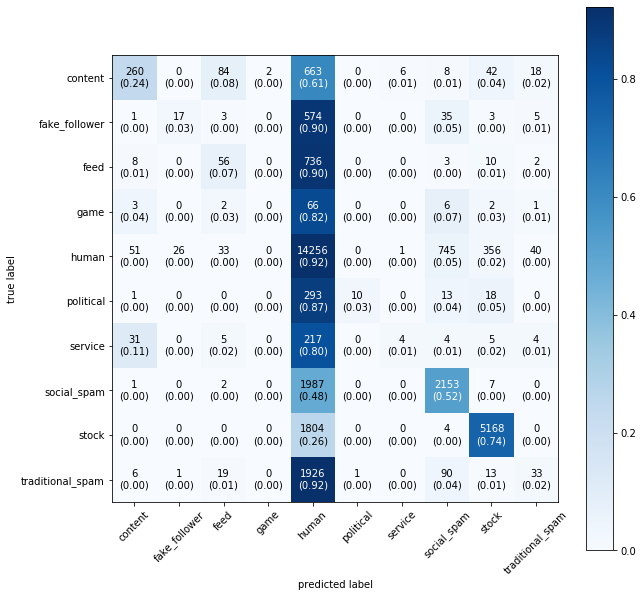

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = LogisticRegression(solver="lbfgs",
                         max_iter=1000,
                         multi_class="ovr",
                         n_jobs=os.cpu_count())

pipeline = Pipeline([("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names, calc_log_loss=True)
print_eval(eval_scores, label_names, console_confm_print=False)

### Data scaling

### Standard Scaler

F1 Score (macro): 0.703
ROC AUC (macro): 0.972
Human Bot AUC: 0.972
Bot type AUC (macro): 0.979
LOG LOSS (mean): 0.363
content
	F1 Score (mean): 0.824
	ROC AUC (mean): 0.991
fake_follower
	F1 Score (mean): 0.400
	ROC AUC (mean): 0.939
feed
	F1 Score (mean): 0.713
	ROC AUC (mean): 0.988
game
	F1 Score (mean): 0.218
	ROC AUC (mean): 0.933
human
	F1 Score (mean): 0.922
	ROC AUC (mean): 0.972
political
	F1 Score (mean): 0.900
	ROC AUC (mean): 0.994
service
	F1 Score (mean): 0.395
	ROC AUC (mean): 0.953
social_spam
	F1 Score (mean): 0.938
	ROC AUC (mean): 0.992
stock
	F1 Score (mean): 0.974
	ROC AUC (mean): 0.996
traditional_spam
	F1 Score (mean): 0.749
	ROC AUC (mean): 0.964


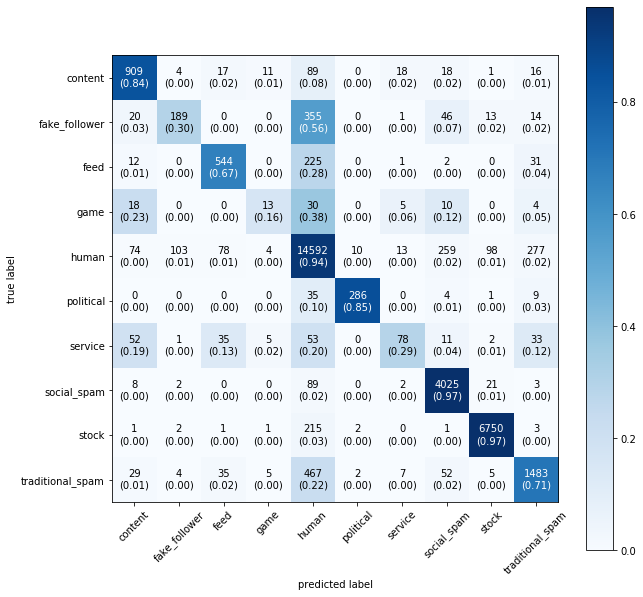

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

clf = LogisticRegression(solver="lbfgs",
                         max_iter=1000,
                         multi_class="ovr",
                         n_jobs=os.cpu_count())

pipeline = Pipeline([("scaling", StandardScaler()), ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names, calc_log_loss=True)
print_eval(eval_scores, label_names, console_confm_print=False)

### min max scaling

F1 Score (macro): 0.657
ROC AUC (macro): 0.971
Human Bot AUC: 0.966
Bot type AUC (macro): 0.974
LOG LOSS (mean): 0.395
content
	F1 Score (mean): 0.813
	ROC AUC (mean): 0.990
fake_follower
	F1 Score (mean): 0.351
	ROC AUC (mean): 0.936
feed
	F1 Score (mean): 0.633
	ROC AUC (mean): 0.987
game
	F1 Score (mean): 0.085
	ROC AUC (mean): 0.946
human
	F1 Score (mean): 0.903
	ROC AUC (mean): 0.966
political
	F1 Score (mean): 0.873
	ROC AUC (mean): 0.989
service
	F1 Score (mean): 0.350
	ROC AUC (mean): 0.951
social_spam
	F1 Score (mean): 0.873
	ROC AUC (mean): 0.988
stock
	F1 Score (mean): 0.972
	ROC AUC (mean): 0.996
traditional_spam
	F1 Score (mean): 0.716
	ROC AUC (mean): 0.963


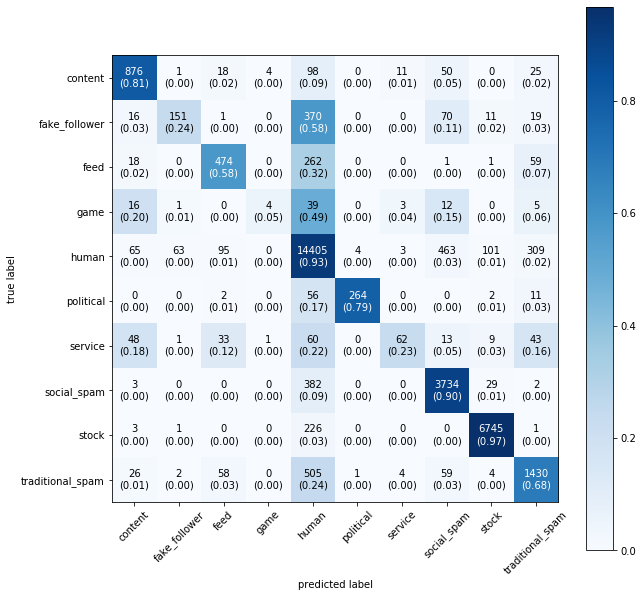

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

clf = LogisticRegression(solver="lbfgs",
                         max_iter=1000,
                         multi_class="ovr",
                         n_jobs=os.cpu_count())
        
pipeline = Pipeline([("scaling", MinMaxScaler()), ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names, calc_log_loss=True)
print_eval(eval_scores, label_names, console_confm_print=False)

### different train sizes

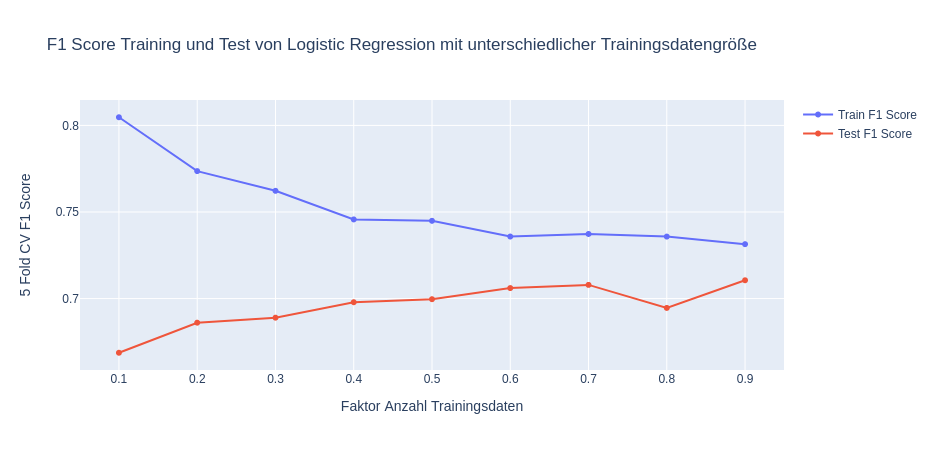

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

clf = LogisticRegression(solver="lbfgs",
                         max_iter=1000,
                         multi_class="ovr",
                         n_jobs=os.cpu_count())

pipeline = Pipeline([("scaling", StandardScaler()), ("clf", clf)])

plot_diff_train_size_f1(pipeline, X, y, "Logistic Regression")

## KNN

Best model: 
- Standard scaler + SMOTE
- F1 Score: 0.776
- ROC AUC: 0.913
- Bot AUC: 0.939
- Bot type AUC: 0.935

### Basic

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

clf = KNeighborsClassifier(n_jobs=os.cpu_count())
pipeline = Pipeline([("clf", clf)])

param_grid = {
    "clf__n_neighbors": range(1,30, 1)
}

scoring = ["f1_macro"]

gs = GridSearchCV(pipeline, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), n_jobs=os.cpu_count(), param_grid=param_grid, scoring=scoring, refit="f1_macro")
gs.fit(X,y)

pp.pprint(gs.cv_results_)
pp.pprint(gs.best_params_)
pp.pprint(gs.best_score_)

{   'mean_fit_time': array([1.13530703, 1.17489271, 1.13718052, 1.16780972, 1.07856264,
       1.0743155 , 1.05520234, 1.09692078, 1.09740047, 1.19728794,
       1.13940468, 1.22425795, 1.1513505 , 1.21700497, 1.16231546,
       1.23225856, 1.17883053, 1.2331809 , 1.26140399, 1.31683545,
       1.24453239, 1.23693042, 1.18671255, 1.30052638, 1.25008578,
       1.33945684, 1.26924477, 1.21620793, 1.21794157]),
    'mean_score_time': array([1.70786204, 1.69737697, 1.7961463 , 1.81188693, 2.08733721,
       2.09570189, 2.13342023, 2.15451374, 2.18993649, 2.0929091 ,
       2.19686747, 2.16054063, 2.34961114, 2.23720264, 2.2931684 ,
       2.25720534, 2.38356853, 2.32602453, 2.35426922, 2.25661588,
       2.42166967, 2.41962538, 2.67096372, 2.51307869, 2.51271043,
       2.46280007, 2.59100885, 2.62977605, 2.38946967]),
    'mean_test_f1_macro': array([0.48026446, 0.48455137, 0.49460752, 0.48957072, 0.48596845,
       0.48603382, 0.48636643, 0.48129648, 0.47859317, 0.47759831,
       0.475

- k: 3
- f1: 0.495

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

clf = KNeighborsClassifier(metric="manhattan", n_jobs=os.cpu_count())
pipeline = Pipeline([("clf", clf)])

param_grid = {
    "clf__n_neighbors": range(1,30)
}

scoring = ["f1_macro"]

gs = GridSearchCV(pipeline, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), n_jobs=os.cpu_count(), param_grid=param_grid, scoring=scoring, refit="f1_macro")
gs.fit(X,y)

pp.pprint(gs.cv_results_)
pp.pprint(gs.best_params_)
pp.pprint(gs.best_score_)

- k: 4
- f1: 0.509

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

clf = KNeighborsClassifier(metric="minkowski", p=3, n_jobs=os.cpu_count())
pipeline = Pipeline([("clf", clf)])

param_grid = {
    "clf__n_neighbors": range(1,30)
}

scoring = ["f1_macro"]

gs = GridSearchCV(pipeline, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), n_jobs=os.cpu_count(), param_grid=param_grid, scoring=scoring, refit="f1_macro")
gs.fit(X,y)

pp.pprint(gs.cv_results_)
pp.pprint(gs.best_params_)
pp.pprint(gs.best_score_)

- k: 3
- f1: 0.492

best:
- k: 4
- dist metric: manhattan

F1 Score (macro): 0.508
ROC AUC (macro): 0.804
Human Bot AUC: 0.905
Bot type AUC (macro): 0.896
content
	F1 Score (mean): 0.569
	ROC AUC (mean): 0.871
fake_follower
	F1 Score (mean): 0.297
	ROC AUC (mean): 0.754
feed
	F1 Score (mean): 0.339
	ROC AUC (mean): 0.753
game
	F1 Score (mean): 0.000
	ROC AUC (mean): 0.552
human
	F1 Score (mean): 0.841
	ROC AUC (mean): 0.905
political
	F1 Score (mean): 0.377
	ROC AUC (mean): 0.755
service
	F1 Score (mean): 0.315
	ROC AUC (mean): 0.680
social_spam
	F1 Score (mean): 0.892
	ROC AUC (mean): 0.968
stock
	F1 Score (mean): 0.895
	ROC AUC (mean): 0.959
traditional_spam
	F1 Score (mean): 0.557
	ROC AUC (mean): 0.841


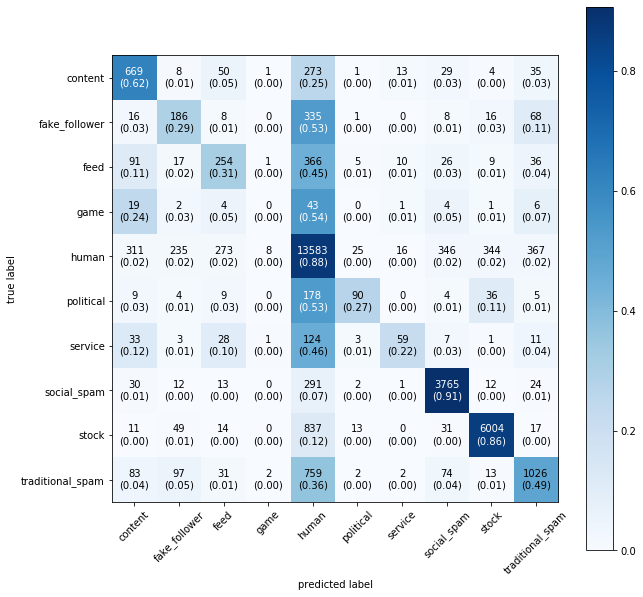

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

clf = KNeighborsClassifier(n_neighbors=4, metric="manhattan", n_jobs=os.cpu_count())
pipeline = Pipeline([("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

### Data scaling

#### Standard Scaler

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

clf = KNeighborsClassifier(metric="manhattan", n_jobs=os.cpu_count())

pipeline = Pipeline([("scaling", StandardScaler()), ("clf", clf)])

estimator_params = {
    "clf__n_neighbors": list(range(1,11,1))
}

gs = CustomGridSearchCV(pipeline, estimator_params=estimator_params)
scores = gs.fit(X, y, label_names)
best_params_idx = np.argmax(scores["f1_scores"])
pp.pprint(scores["f1_scores"][best_params_idx])
pp.pprint(scores["params"][best_params_idx])
pp.pprint(scores["fold_scores"][best_params_idx])

Number of fits: 10
10/10 (avg 184.61s/job)0.7585495734604277
({'clf__n_neighbors': 4}, {})
{   'bot_aucs': [   0.9373923931757708,
                    0.9389575833463766,
                    0.9389575833463766,
                    0.940992330568164,
                    0.9391045710707576],
    'bot_type_aucs': [   0.9322272656127719,
                         0.9339489748004383,
                         0.9342620128345595,
                         0.936609798090468,
                         0.9361302442078898],
    'class_scores': {   'content': {   'f1_scores': [   0.7671840354767184,
                                                        0.7982261640798226,
                                                        0.7855530474040633,
                                                        0.8070175438596491,
                                                        0.8475336322869955],
                                       'roc_aucs': [   0.9268336115831569,
                            

Process GridSearchWatch-1:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "../evaluation/evaluate.py", line 274, in run
    worker_time = self.worker_times_q.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 94, in get
    res = self._recv_bytes()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


best k=4

calculating K-Fold 1/5
1 Fold time: 8.29s
calculating K-Fold 2/5
2 Fold time: 8.85s
calculating K-Fold 3/5
3 Fold time: 9.35s
calculating K-Fold 4/5
4 Fold time: 9.38s
calculating K-Fold 5/5
5 Fold time: 9.96s

Total time: 45.85s

Finished K-Fold evaluation
F1 Score: 0.759
ROC AUC: 0.912
Bot AUC: 0.939
Bot type AUC: 0.935
content
	F1 Score: 0.801
	ROC AUC: 0.948
fake_follower
	F1 Score: 0.528
	ROC AUC: 0.830
feed
	F1 Score: 0.791
	ROC AUC: 0.952
game
	F1 Score: 0.207
	ROC AUC: 0.692
human
	F1 Score: 0.938
	ROC AUC: 0.971
political
	F1 Score: 0.963
	ROC AUC: 0.988
service
	F1 Score: 0.544
	ROC AUC: 0.812
social_spam
	F1 Score: 0.975
	ROC AUC: 0.991
stock
	F1 Score: 0.977
	ROC AUC: 0.989
traditional_spam
	F1 Score: 0.862
	ROC AUC: 0.948


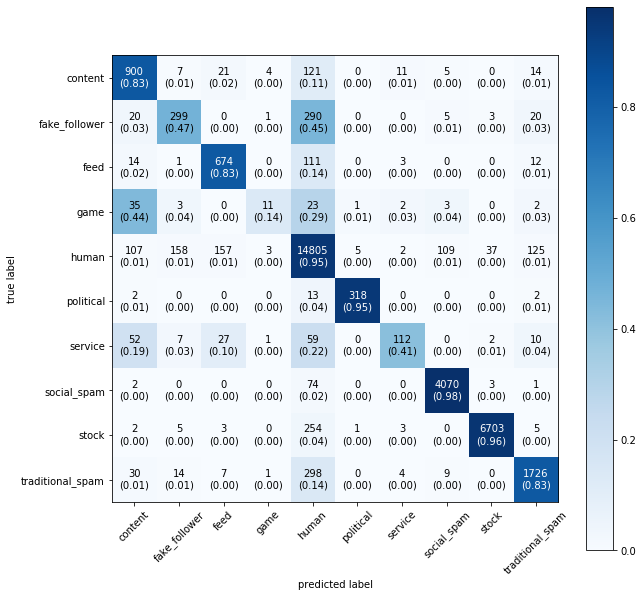

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

clf = KNeighborsClassifier(n_neighbors=4, metric="manhattan", n_jobs=os.cpu_count())
pipeline = Pipeline([("scaling", StandardScaler()), ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names, verbose=True)
print_eval(eval_scores, label_names, console_confm_print=False)

#### min max scaling

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

clf = KNeighborsClassifier(metric="manhattan", n_jobs=os.cpu_count())

pipeline = Pipeline([("scaling", MinMaxScaler()), ("clf", clf)])

estimator_params = {
    "clf__n_neighbors": list(range(1,11,1))
}

gs = CustomGridSearchCV(pipeline, estimator_params=estimator_params)
scores = gs.fit(X, y, label_names)
best_params_idx = np.argmax(scores["f1_scores"])
pp.pprint(scores["f1_scores"][best_params_idx])
pp.pprint(scores["params"][best_params_idx])
pp.pprint(scores["fold_scores"][best_params_idx])

Number of fits: 10
10/10 (avg 335.39s/job)0.7504069142066103
({'clf__n_neighbors': 4}, {})
{   'bot_aucs': [   0.9378619502269526,
                    0.940992330568164,
                    0.9386445453122554,
                    0.9391141023634372,
                    0.9364433312460864],
    'bot_type_aucs': [   0.9320707465957114,
                         0.9369228361245892,
                         0.9350446079198622,
                         0.9350446079198622,
                         0.932216656230432],
    'class_scores': {   'content': {   'f1_scores': [   0.7592592592592593,
                                                        0.8144796380090498,
                                                        0.8018223234624147,
                                                        0.8053691275167787,
                                                        0.851258581235698],
                                       'roc_aucs': [   0.9201104437761138,
                             

Process GridSearchWatch-15:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "../evaluation/evaluate.py", line 274, in run
    worker_time = self.worker_times_q.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 94, in get
    res = self._recv_bytes()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


best k=4

calculating K-Fold 1/5
1 Fold time: 13.62s
calculating K-Fold 2/5
2 Fold time: 15.25s
calculating K-Fold 3/5
3 Fold time: 14.21s
calculating K-Fold 4/5
4 Fold time: 14.13s
calculating K-Fold 5/5
5 Fold time: 13.74s

Total time: 70.96s

Finished K-Fold evaluation
F1 Score: 0.750
ROC AUC: 0.911
Bot AUC: 0.939
Bot type AUC: 0.934
content
	F1 Score: 0.806
	ROC AUC: 0.943
fake_follower
	F1 Score: 0.500
	ROC AUC: 0.818
feed
	F1 Score: 0.785
	ROC AUC: 0.956
game
	F1 Score: 0.186
	ROC AUC: 0.698
human
	F1 Score: 0.938
	ROC AUC: 0.970
political
	F1 Score: 0.940
	ROC AUC: 0.988
service
	F1 Score: 0.529
	ROC AUC: 0.806
social_spam
	F1 Score: 0.976
	ROC AUC: 0.991
stock
	F1 Score: 0.978
	ROC AUC: 0.990
traditional_spam
	F1 Score: 0.864
	ROC AUC: 0.951


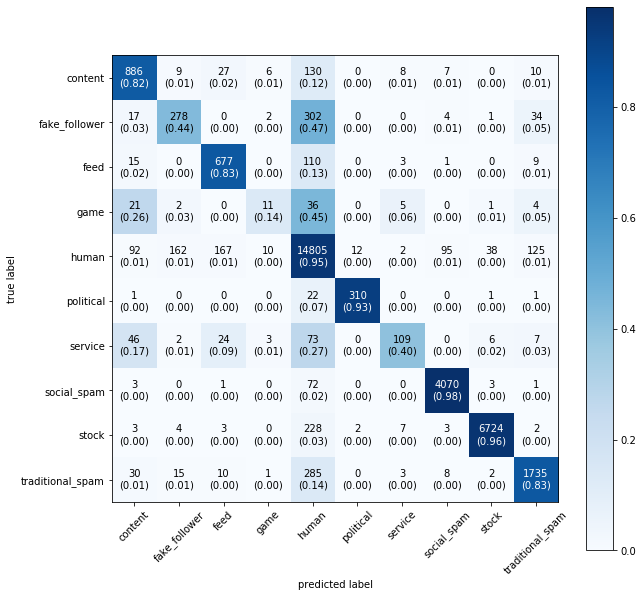

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

clf = KNeighborsClassifier(n_neighbors=4, metric="manhattan", n_jobs=os.cpu_count())
pipeline = Pipeline([("scaling", MinMaxScaler()), ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names, verbose=True)
print_eval(eval_scores, label_names, console_confm_print=False)

### PCA

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

clf = KNeighborsClassifier(metric="manhattan", n_jobs=os.cpu_count())

        
pipeline = Pipeline([("pca", PCA()), ("clf", clf)])

param_grid = {
    "pca__n_components": range(55, 65, 1),
    "clf__n_neighbors": range(1, 6, 1)
}

scoring = ["f1_macro"]

gs = GridSearchCV(pipeline, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), n_jobs=os.cpu_count(), verbose=1, param_grid=param_grid, scoring=scoring, refit="f1_macro")
gs.fit(X,y)

#pp.pprint(gs.cv_results_)
pp.pprint(gs.best_params_)
pp.pprint(gs.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   19.6s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 250 out of 250 | elapsed:  2.0min finished


{'clf__n_neighbors': 3, 'pca__n_components': 63}
0.5090232387354815


F1 Score (macro): 0.509
ROC AUC (macro): 0.790
Human Bot AUC: 0.895
Bot type AUC (macro): 0.884
content
	F1 Score (mean): 0.553
	ROC AUC (mean): 0.853
fake_follower
	F1 Score (mean): 0.284
	ROC AUC (mean): 0.724
feed
	F1 Score (mean): 0.320
	ROC AUC (mean): 0.726
game
	F1 Score (mean): 0.054
	ROC AUC (mean): 0.553
human
	F1 Score (mean): 0.837
	ROC AUC (mean): 0.895
political
	F1 Score (mean): 0.346
	ROC AUC (mean): 0.742
service
	F1 Score (mean): 0.333
	ROC AUC (mean): 0.660
social_spam
	F1 Score (mean): 0.899
	ROC AUC (mean): 0.965
stock
	F1 Score (mean): 0.897
	ROC AUC (mean): 0.954
traditional_spam
	F1 Score (mean): 0.567
	ROC AUC (mean): 0.824


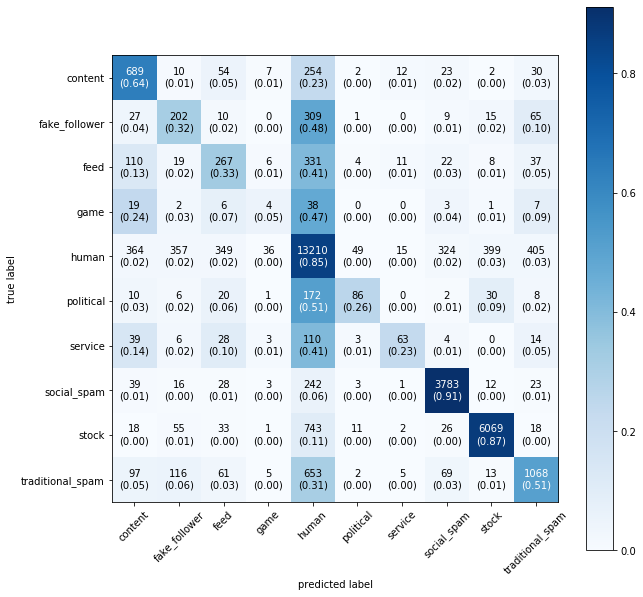

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

clf = KNeighborsClassifier(n_neighbors=3, metric="manhattan", n_jobs=os.cpu_count())

pipeline = Pipeline([("pca", PCA(n_components=63)), ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

### Scaling + PCA

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

clf = KNeighborsClassifier(metric="manhattan", n_jobs=os.cpu_count())

        
pipeline = Pipeline([("scaling", StandardScaler()), ("pca", PCA()), ("clf", clf)])

param_grid = {
    "pca__n_components": range(155, X.shape[1] + 1, 1),
    "clf__n_neighbors": range(4, 5, 1)
}

scoring = ["f1_macro"]

gs = GridSearchCV(pipeline, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), n_jobs=os.cpu_count(), verbose=1, param_grid=param_grid, scoring=scoring, refit="f1_macro")
gs.fit(X,y)

#pp.pprint(gs.cv_results_)
pp.pprint(gs.best_params_)
pp.pprint(gs.best_score_)

Fitting 5 folds for each of 17 candidates, totalling 85 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed: 10.2min
[Parallel(n_jobs=6)]: Done  85 out of  85 | elapsed: 21.1min finished


{'clf__n_neighbors': 4, 'pca__n_components': 159}
0.7487866695838823


F1 Score (macro): 0.749
ROC AUC (macro): 0.906
Human Bot AUC: 0.968
Bot type AUC (macro): 0.964
content
	F1 Score (mean): 0.803
	ROC AUC (mean): 0.940
fake_follower
	F1 Score (mean): 0.496
	ROC AUC (mean): 0.821
feed
	F1 Score (mean): 0.769
	ROC AUC (mean): 0.944
game
	F1 Score (mean): 0.232
	ROC AUC (mean): 0.686
human
	F1 Score (mean): 0.934
	ROC AUC (mean): 0.968
political
	F1 Score (mean): 0.945
	ROC AUC (mean): 0.983
service
	F1 Score (mean): 0.501
	ROC AUC (mean): 0.794
social_spam
	F1 Score (mean): 0.975
	ROC AUC (mean): 0.992
stock
	F1 Score (mean): 0.974
	ROC AUC (mean): 0.988
traditional_spam
	F1 Score (mean): 0.858
	ROC AUC (mean): 0.944


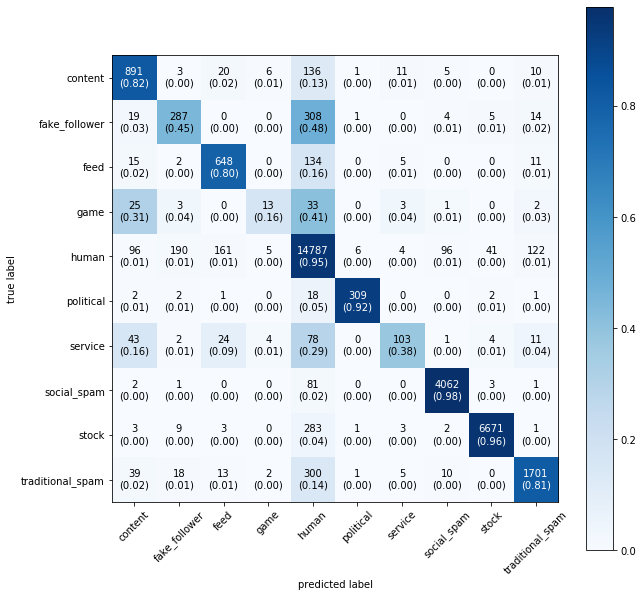

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

clf = KNeighborsClassifier(n_neighbors=4, metric="manhattan", n_jobs=os.cpu_count())

pipeline = Pipeline([("scaling", StandardScaler()), ("pca", PCA(n_components=159)), ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

### oversampling game class

#### adasyn

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

clf = KNeighborsClassifier(metric="manhattan", n_jobs=os.cpu_count())

pipeline = Pipeline([("scaling", StandardScaler()), ("clf", clf)])

estimator_params = {
    "clf__n_neighbors": list(range(1,100,1)),
}

train_preproc_params = {
    "n_neighbors": list(range(1,100,1)),
    "sampling_strategy": [{3:800}]
}

gs = CustomGridSearchCV(pipeline, estimator_params=estimator_params)
scores = gs.fit(X, y, label_names, train_preproc_func=oversampling_adasyn, train_preproc_params=train_preproc_params)
best_params_idx = np.argmax(scores["f1_scores"])
pp.pprint(scores["f1_scores"][best_params_idx])
pp.pprint(scores["params"][best_params_idx])
pp.pprint(scores["fold_scores"][best_params_idx])

best:
 - knn:
  - n_neighbors: 4
 - smote:
  - k_neighbors: 45
  - sampling_strategy: 3:800

F1 Score (macro): 0.771
ROC AUC (macro): 0.915
Human Bot AUC: 0.971
Bot type AUC (macro): 0.968
content
	F1 Score (mean): 0.803
	ROC AUC (mean): 0.944
fake_follower
	F1 Score (mean): 0.530
	ROC AUC (mean): 0.830
feed
	F1 Score (mean): 0.794
	ROC AUC (mean): 0.953
game
	F1 Score (mean): 0.321
	ROC AUC (mean): 0.730
human
	F1 Score (mean): 0.939
	ROC AUC (mean): 0.971
political
	F1 Score (mean): 0.963
	ROC AUC (mean): 0.987
service
	F1 Score (mean): 0.543
	ROC AUC (mean): 0.804
social_spam
	F1 Score (mean): 0.975
	ROC AUC (mean): 0.991
stock
	F1 Score (mean): 0.977
	ROC AUC (mean): 0.989
traditional_spam
	F1 Score (mean): 0.863
	ROC AUC (mean): 0.948


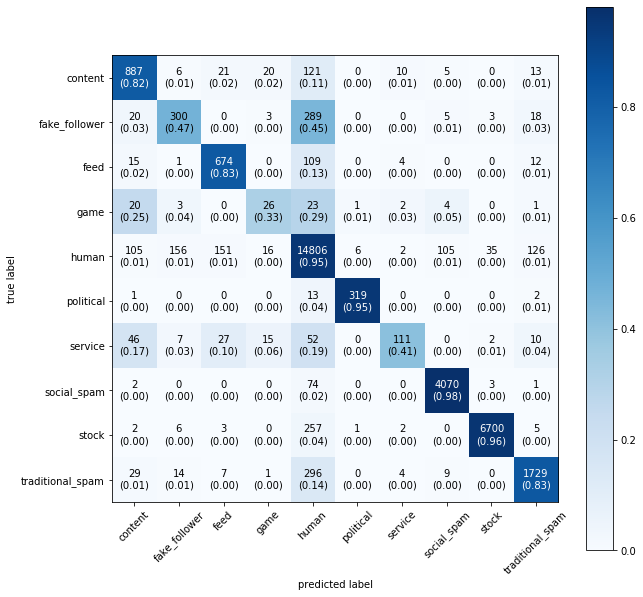

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

clf = KNeighborsClassifier(n_neighbors=4, metric="manhattan", n_jobs=os.cpu_count())


pipeline = Pipeline([
    ("smote", SMOTE(sampling_strategy={3:800}, k_neighbors=45, random_state=42, n_jobs=os.cpu_count())),
    ("scaling", StandardScaler()),
    ("clf", clf)])


eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

#### smote

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

clf = KNeighborsClassifier(metric="manhattan", n_jobs=os.cpu_count())

pipeline = Pipeline([("scaling", StandardScaler()), ("clf", clf)])

estimator_params = {
    "clf__n_neighbors": list(range(1,10,1)),
}

train_preproc_params = {
    "k_neighbors": list(range(10,31,1)),
    "sampling_strategy": [{3:800}]
}

gs = CustomGridSearchCV(pipeline, estimator_params=estimator_params)
scores = gs.fit(X, y, label_names, train_preproc_func=oversampling_smote, train_preproc_params=train_preproc_params)
best_params_idx = np.argmax(scores["f1_scores"])
pp.pprint(scores["f1_scores"][best_params_idx])
pp.pprint(scores["params"][best_params_idx])
#pp.pprint(scores["fold_scores"][best_params_idx])

best:
 - knn:
  - n_neighbors: 4
 - smote:
  - k_neighbors: 41
  - sampling_strategy: 3:800

F1 Score (macro): 0.776
ROC AUC (macro): 0.913
Human Bot AUC: 0.971
Bot type AUC (macro): 0.968
content
	F1 Score (mean): 0.804
	ROC AUC (mean): 0.943
fake_follower
	F1 Score (mean): 0.532
	ROC AUC (mean): 0.830
feed
	F1 Score (mean): 0.793
	ROC AUC (mean): 0.953
game
	F1 Score (mean): 0.365
	ROC AUC (mean): 0.711
human
	F1 Score (mean): 0.939
	ROC AUC (mean): 0.971
political
	F1 Score (mean): 0.963
	ROC AUC (mean): 0.986
service
	F1 Score (mean): 0.546
	ROC AUC (mean): 0.806
social_spam
	F1 Score (mean): 0.974
	ROC AUC (mean): 0.991
stock
	F1 Score (mean): 0.977
	ROC AUC (mean): 0.989
traditional_spam
	F1 Score (mean): 0.863
	ROC AUC (mean): 0.948


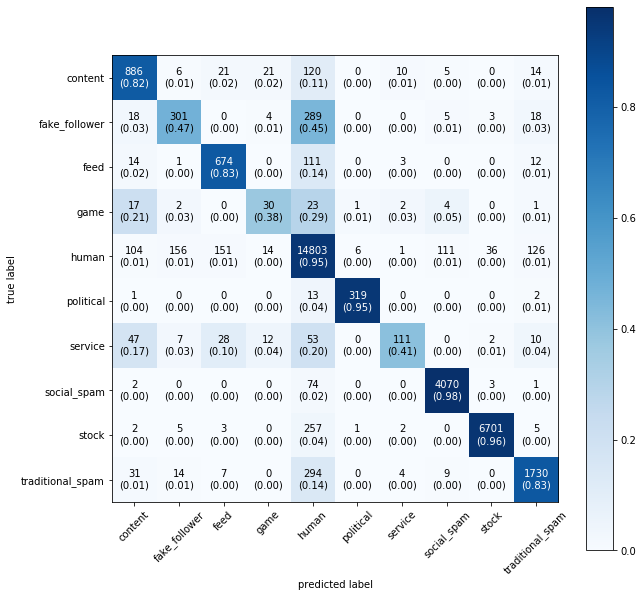

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

clf = KNeighborsClassifier(n_neighbors=4, metric="manhattan", n_jobs=os.cpu_count())


pipeline = Pipeline([
    ("smote", SMOTE(sampling_strategy={3:800}, k_neighbors=41, random_state=42, n_jobs=os.cpu_count())),
    ("scaling", StandardScaler()),
    ("clf", clf)])


eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

### different train sizes

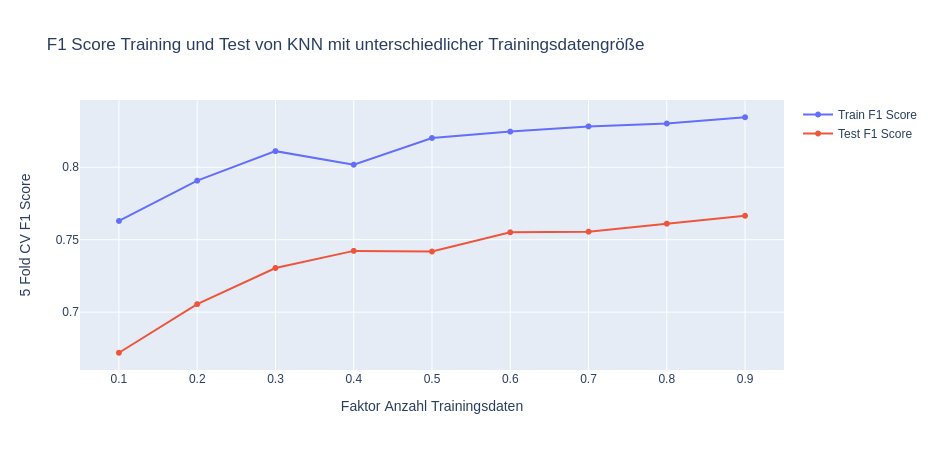

In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

clf = KNeighborsClassifier(n_neighbors=4, metric="manhattan", n_jobs=os.cpu_count())
pipeline = Pipeline([("scaling", StandardScaler()), ("clf", clf)])

plot_diff_train_size_f1(pipeline, X, y, "KNN")

## BNB

Best model:
- sklearn binnning + ADASYN
- F1 Score: 0.610
- ROC AUC: 0.966
- Bot AUC: 0.875
- Bot type AUC: 0.860

### binning + var threshold

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer

clf = BernoulliNB()
pipeline = Pipeline([
    ("feature_binning", ColumnTransformer(
        transformers=[
            ("binning", KBinsDiscretizer(encode="onehot"), continous_features_idx)
        ],
        remainder="passthrough")),
    ("var_threshold", VarianceThreshold()),
    ("clf", clf)])
 
param_grid = {
    "feature_binning__binning__n_bins": range(1,40,1),
    "feature_binning__binning__strategy": ["quantile", "kmeans", "uniform"],
}

scoring = ["f1_macro"]

gs = GridSearchCV(pipeline, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), n_jobs=os.cpu_count(), param_grid=param_grid, scoring=scoring, refit="f1_macro")
gs.fit(X,y)

#pp.pprint(gs.cv_results_)
pp.pprint(gs.best_params_)
pp.pprint(gs.best_score_)

/home/infinityofspace/PycharmProjects/twitter-bot-classification/venv/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning:

Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.

/home/infinityofspace/PycharmProjects/twitter-bot-classification/venv/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning:

Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.

/home/infinityofspace/PycharmProjects/twitter-bot-classification/venv/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning:

Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.

/home/infinityofspace/PycharmProjects/twitter-bot-classification/venv/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:197: UserWarning:

Bins whose width are too s

{   'mean_fit_time': array([ 0.17066202,  0.15702767,  0.15580106,  1.42672443,  3.48224406,
        1.35248017,  1.62477479,  5.52003331,  2.02250528,  2.29784021,
        8.3627666 ,  5.07436972,  4.42735448,  9.45749936,  2.22866268,
        3.48018112, 12.54068837,  3.93165994,  3.59322009, 13.17173533,
        4.69012833,  4.3766974 , 15.37760277,  1.24422908,  4.83086457,
       15.81528053,  1.21906791,  2.98251624, 20.40586696,  1.15976644,
        1.35460443, 19.0648675 ,  1.14364824,  1.29282455, 21.6710197 ,
        1.09785385,  1.21235018, 23.54855208,  1.11817875,  1.33009801,
       24.18210459,  1.06908131,  1.30321884, 26.03337216,  1.12658181,
        1.30967598, 26.21421432,  1.15999336,  1.30645695, 30.49805398,
        1.1368475 ,  1.29239001, 31.58172169,  1.09467196,  1.29082537,
       29.7109437 ,  0.61840692,  1.34616108, 35.56682768,  1.15396538,
        1.30959287, 36.38806825,  1.11004887,  1.35945153, 38.23183107,
        1.11128674,  1.33052897, 37.9411542

F1 Score (macro): 0.603
ROC AUC (macro): 0.965
Human Bot AUC: 0.930
Bot type AUC (macro): 0.963
content
	F1 Score (mean): 0.725
	ROC AUC (mean): 0.987
fake_follower
	F1 Score (mean): 0.330
	ROC AUC (mean): 0.933
feed
	F1 Score (mean): 0.522
	ROC AUC (mean): 0.971
game
	F1 Score (mean): 0.163
	ROC AUC (mean): 0.930
human
	F1 Score (mean): 0.856
	ROC AUC (mean): 0.942
political
	F1 Score (mean): 0.641
	ROC AUC (mean): 0.982
service
	F1 Score (mean): 0.230
	ROC AUC (mean): 0.953
social_spam
	F1 Score (mean): 0.950
	ROC AUC (mean): 0.990
stock
	F1 Score (mean): 0.966
	ROC AUC (mean): 0.996
traditional_spam
	F1 Score (mean): 0.650
	ROC AUC (mean): 0.962


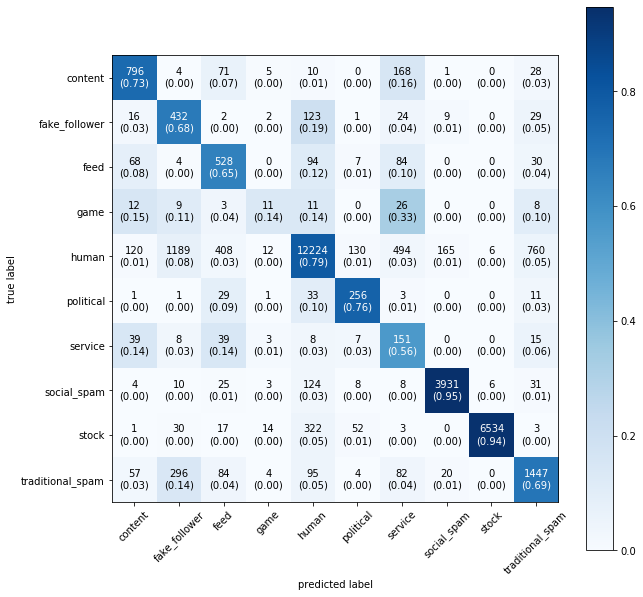

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer

clf = BernoulliNB()

pipeline = Pipeline([
    ("feature_binning", ColumnTransformer(
        transformers=[
            ("binning", KBinsDiscretizer(encode="onehot", strategy="quantile", n_bins=33), continous_features_idx)
        ],
        remainder="passthrough")),
    ("var_threshold", VarianceThreshold()),
    ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

#### binning + var threshold + select k best

In [27]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold
from sklearn.compose import ColumnTransformer

clf = BernoulliNB()
pipeline = Pipeline([
    ("feature_binning", ColumnTransformer(
        transformers=[
            ("binning", KBinsDiscretizer(encode="onehot"), continous_features_idx)
        ],
        remainder="passthrough")),
    ("var_threshold", VarianceThreshold()),
    ('feature_selection', SelectKBest(score_func=chi2)),
    ("clf", clf)])
 
params = {
    "feature_binning__binning__n_bins": range(7,10,1),
    "feature_binning__binning__strategy": ["quantile"],
    "feature_selection__k": range(180, 192, 1)
}

scoring = ["f1_macro"]

gs = CustomGridSearchCV(pipeline, params=params)
scores = gs.fit(X, y, label_names)
best_params_idx = np.argmax(scores["f1_scores"])
pp.pprint(scores["f1_scores"][best_params_idx])
pp.pprint(scores["params"][best_params_idx])

Number of fits: 36
36/36 (avg 12.64s/job)0.5700300044550006
{   'feature_binning__binning__n_bins': 8,
    'feature_binning__binning__strategy': 'quantile',
    'feature_selection__k': 185}


F1 Score (macro): 0.570
ROC AUC (macro): 0.954
Human Bot AUC: 0.919
Bot type AUC (macro): 0.952
content
	F1 Score (mean): 0.672
	ROC AUC (mean): 0.985
fake_follower
	F1 Score (mean): 0.276
	ROC AUC (mean): 0.905
feed
	F1 Score (mean): 0.491
	ROC AUC (mean): 0.959
game
	F1 Score (mean): 0.133
	ROC AUC (mean): 0.915
human
	F1 Score (mean): 0.845
	ROC AUC (mean): 0.925
political
	F1 Score (mean): 0.643
	ROC AUC (mean): 0.964
service
	F1 Score (mean): 0.186
	ROC AUC (mean): 0.947
social_spam
	F1 Score (mean): 0.882
	ROC AUC (mean): 0.984
stock
	F1 Score (mean): 0.962
	ROC AUC (mean): 0.994
traditional_spam
	F1 Score (mean): 0.611
	ROC AUC (mean): 0.956


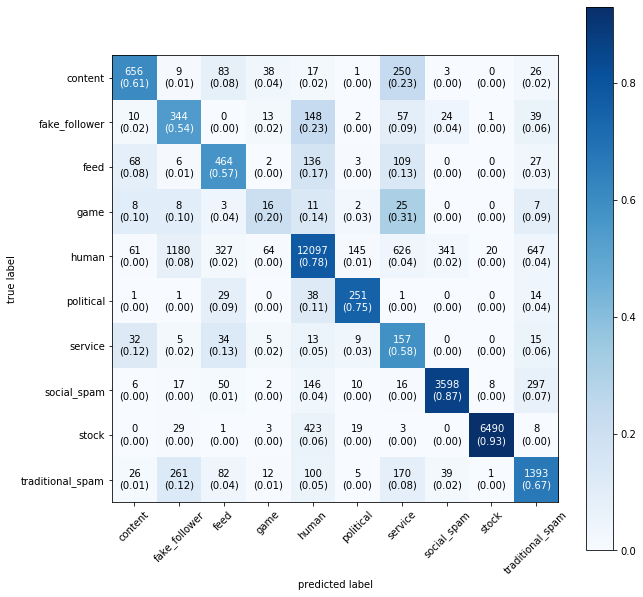

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold

clf = BernoulliNB()

pipeline = Pipeline([
    ("feature_binning", ColumnTransformer(
        transformers=[
            ("binning", KBinsDiscretizer(encode="onehot", strategy="quantile", n_bins=8), continous_features_idx)
        ],
        remainder="passthrough")),
    ("var_threshold", VarianceThreshold()),
    ('feature_selection', SelectKBest(score_func=chi2, k=185)),
    ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

### custom binning

F1 Score (macro): 0.603
ROC AUC (macro): 0.966
Human Bot AUC: 0.927
Bot type AUC (macro): 0.961
content
	F1 Score (mean): 0.734
	ROC AUC (mean): 0.988
fake_follower
	F1 Score (mean): 0.318
	ROC AUC (mean): 0.930
feed
	F1 Score (mean): 0.531
	ROC AUC (mean): 0.974
game
	F1 Score (mean): 0.138
	ROC AUC (mean): 0.942
human
	F1 Score (mean): 0.851
	ROC AUC (mean): 0.939
political
	F1 Score (mean): 0.690
	ROC AUC (mean): 0.987
service
	F1 Score (mean): 0.235
	ROC AUC (mean): 0.955
social_spam
	F1 Score (mean): 0.938
	ROC AUC (mean): 0.989
stock
	F1 Score (mean): 0.962
	ROC AUC (mean): 0.996
traditional_spam
	F1 Score (mean): 0.633
	ROC AUC (mean): 0.960


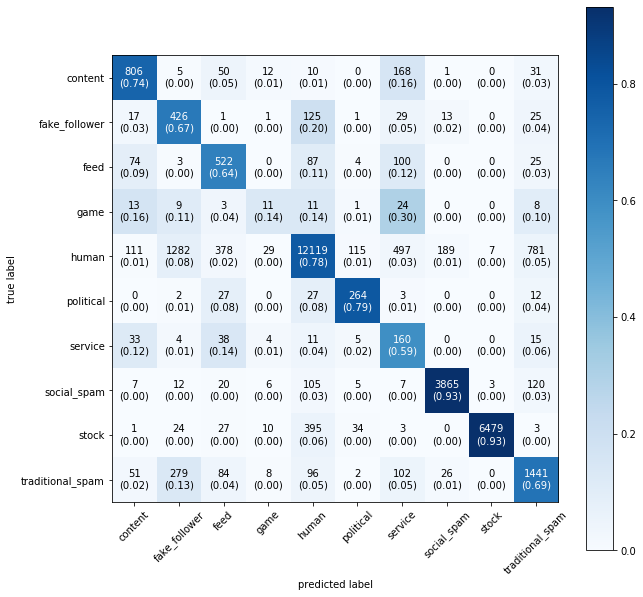

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder

percentiles = [
    99.9,
    95,
    90,
    85,
    80,
    75,
    70,
    65,
    60,
    55,
    50,
    45,
    40,
    35,
    30,
    25,
    20,
    15,
    10,
    5,
    0.01
]

def custom_column_transformer(X):
    X_new = np.empty_like(X)
    for i in range(X.shape[1]):
        bins = [np.percentile(X[:,i], p) for p in percentiles]
        binned = np.digitize(X[:,i], bins, right=False)
        X_new[:,i] = binned

    return X_new


clf = BernoulliNB()

ct = ColumnTransformer(
        transformers=[
            ("binning", FunctionTransformer(func=custom_column_transformer), continous_features_idx),
        ],
        remainder="passthrough",
        n_jobs=os.cpu_count())

X_new = ct.fit_transform(X)
X_new = OneHotEncoder(sparse=False).fit_transform(X_new)
X_new = VarianceThreshold().fit_transform(X_new)

eval_scores = evaluate_model(clf, X_new, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

### select k best chi square

F1 Score (macro): 0.360
ROC AUC (macro): 0.868
Human Bot AUC: 0.869
Bot type AUC (macro): 0.858
content
	F1 Score (mean): 0.092
	ROC AUC (mean): 0.790
fake_follower
	F1 Score (mean): 0.009
	ROC AUC (mean): 0.768
feed
	F1 Score (mean): 0.000
	ROC AUC (mean): 0.825
game
	F1 Score (mean): 0.000
	ROC AUC (mean): 0.825
human
	F1 Score (mean): 0.823
	ROC AUC (mean): 0.869
political
	F1 Score (mean): 0.560
	ROC AUC (mean): 0.950
service
	F1 Score (mean): 0.000
	ROC AUC (mean): 0.832
social_spam
	F1 Score (mean): 0.698
	ROC AUC (mean): 0.935
stock
	F1 Score (mean): 0.936
	ROC AUC (mean): 0.984
traditional_spam
	F1 Score (mean): 0.478
	ROC AUC (mean): 0.905


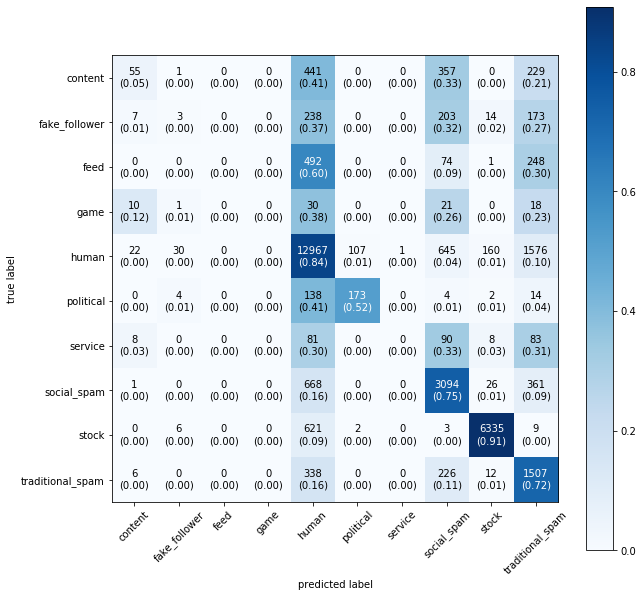

In [29]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder

percentiles = [
    99.9,
    95,
    90,
    85,
    80,
    75,
    70,
    65,
    60,
    55,
    50,
    45,
    40,
    35,
    30,
    25,
    20,
    15,
    10,
    5,
    0.01
]

def custom_column_transformer(X):
    X_new = np.empty_like(X)
    for i in range(X.shape[1]):
        bins = [np.percentile(X[:,i], p) for p in percentiles]
        binned = np.digitize(X[:,i], bins, right=False)
        X_new[:,i] = binned

    return X_new


clf = BernoulliNB()

ct = ColumnTransformer(
        transformers=[
            ("binning", FunctionTransformer(func=custom_column_transformer), continous_features_idx),
        ],
        remainder="passthrough",
        n_jobs=os.cpu_count())

X_new = ct.fit_transform(X)
X_new = OneHotEncoder(sparse=False).fit_transform(X_new)
X_new = VarianceThreshold().fit_transform(X_new)
X_new = SelectKBest(score_func=chi2).fit_transform(X_new, y)

eval_scores = evaluate_model(clf, X_new, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

### oversampling game class

#### adasyn

In [22]:
from imblearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import ADASYN

clf = BernoulliNB()

pipeline = Pipeline([
    ("adasyn", ADASYN(random_state=42, n_jobs=os.cpu_count())),
    ("feature_binning", ColumnTransformer(
        transformers=[
            ("binning", KBinsDiscretizer(encode="onehot"), continous_features_idx)
        ],
        remainder="passthrough")),
    ("var_threshold", VarianceThreshold()),
    ("clf", clf)])

params = {
    "feature_binning__binning__n_bins": range(60,71,1),
    "feature_binning__binning__strategy": ["quantile"],
    "adasyn__n_neighbors": range(1,10,1),
    "adasyn__sampling_strategy": [{3:800}]
}

gs = CustomGridSearchCV(pipeline, params=params)
scores = gs.fit(X, y, label_names)
best_params_idx = np.argmax(scores["f1_scores"])
pp.pprint(scores["f1_scores"][best_params_idx])
pp.pprint(scores["params"][best_params_idx])
# pp.pprint(scores["fold_scores"][best_params_idx])

Number of fits: 99
99/99 (avg 18.04s/job, total: 5.2min)0.6103692269876368
{   'adasyn__n_neighbors': 3,
    'adasyn__sampling_strategy': {3: 800},
    'feature_binning__binning__n_bins': 60,
    'feature_binning__binning__strategy': 'quantile'}


Process GridSearchWatch-29:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "../evaluation/evaluate2.py", line 219, in run
    worker_time = self.worker_times_q.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 94, in get
    res = self._recv_bytes()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


F1 Score (macro): 0.610
ROC AUC (macro): 0.966
Human Bot AUC: 0.934
Bot type AUC (macro): 0.965
content
	F1 Score (mean): 0.710
	ROC AUC (mean): 0.986
fake_follower
	F1 Score (mean): 0.354
	ROC AUC (mean): 0.937
feed
	F1 Score (mean): 0.543
	ROC AUC (mean): 0.973
game
	F1 Score (mean): 0.147
	ROC AUC (mean): 0.939
human
	F1 Score (mean): 0.860
	ROC AUC (mean): 0.946
political
	F1 Score (mean): 0.655
	ROC AUC (mean): 0.983
service
	F1 Score (mean): 0.265
	ROC AUC (mean): 0.951
social_spam
	F1 Score (mean): 0.953
	ROC AUC (mean): 0.989
stock
	F1 Score (mean): 0.967
	ROC AUC (mean): 0.996
traditional_spam
	F1 Score (mean): 0.649
	ROC AUC (mean): 0.963


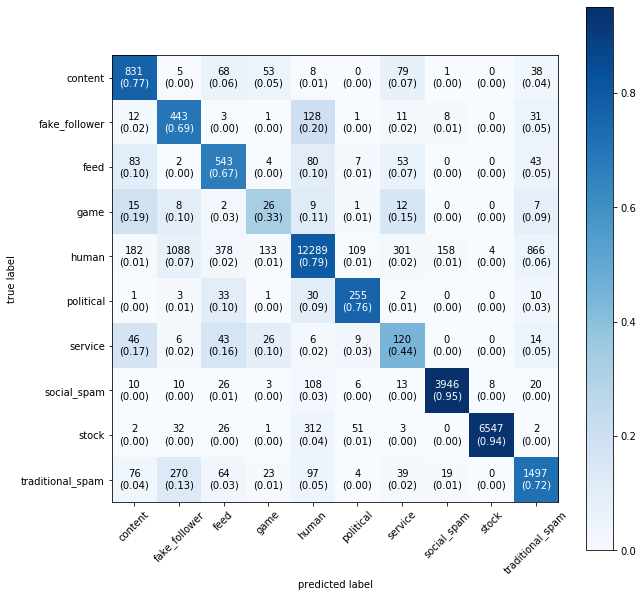

In [30]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN

clf = BernoulliNB()

pipeline = Pipeline([
    ("adasyn", ADASYN(sampling_strategy={3:800}, n_neighbors=3, random_state=42, n_jobs=os.cpu_count())),
    ("feature_binning", ColumnTransformer(
        transformers=[
            ("binning", KBinsDiscretizer(encode="onehot", strategy="quantile", n_bins=60), continous_features_idx)
        ],
        remainder="passthrough")),
    ("var_threshold", VarianceThreshold()),
    ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

#### smote

In [21]:
from imblearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE

clf = BernoulliNB()

pipeline = Pipeline([
    ("smote", SMOTE(random_state=42, n_jobs=os.cpu_count())),
    ("feature_binning", ColumnTransformer(
        transformers=[
            ("binning", KBinsDiscretizer(encode="onehot"), continous_features_idx)
        ],
        remainder="passthrough")),
    ("var_threshold", VarianceThreshold()),
    ("clf", clf)])

params = {
    "feature_binning__binning__n_bins": range(40,51,1),
    "feature_binning__binning__strategy": ["quantile"],
    "smote__k_neighbors": range(1,10,1),
    "smote__sampling_strategy": [{3:800}]
}

gs = CustomGridSearchCV(pipeline, params=params)
scores = gs.fit(X, y, label_names)
best_params_idx = np.argmax(scores["f1_scores"])
pp.pprint(scores["f1_scores"][best_params_idx])
pp.pprint(scores["params"][best_params_idx])
# pp.pprint(scores["fold_scores"][best_params_idx])

Number of fits: 99
99/99 (avg 3.63s/job, total: 1.1min)0.6088931443417476
{   'feature_binning__binning__n_bins': 45,
    'feature_binning__binning__strategy': 'quantile',
    'smote__k_neighbors': 2,
    'smote__sampling_strategy': {3: 800}}


F1 Score (macro): 0.609
ROC AUC (macro): 0.966
Human Bot AUC: 0.932
Bot type AUC (macro): 0.964
content
	F1 Score (mean): 0.724
	ROC AUC (mean): 0.987
fake_follower
	F1 Score (mean): 0.345
	ROC AUC (mean): 0.935
feed
	F1 Score (mean): 0.529
	ROC AUC (mean): 0.972
game
	F1 Score (mean): 0.154
	ROC AUC (mean): 0.939
human
	F1 Score (mean): 0.858
	ROC AUC (mean): 0.944
political
	F1 Score (mean): 0.663
	ROC AUC (mean): 0.982
service
	F1 Score (mean): 0.245
	ROC AUC (mean): 0.953
social_spam
	F1 Score (mean): 0.953
	ROC AUC (mean): 0.989
stock
	F1 Score (mean): 0.967
	ROC AUC (mean): 0.996
traditional_spam
	F1 Score (mean): 0.652
	ROC AUC (mean): 0.963


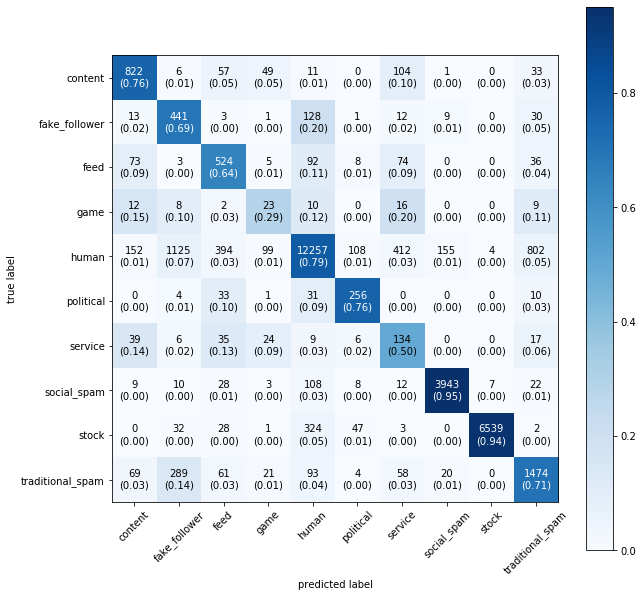

In [31]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

clf = BernoulliNB()

pipeline = Pipeline([
    ("smote", SMOTE(sampling_strategy={3:800}, k_neighbors=2, random_state=42, n_jobs=os.cpu_count())),
    ("feature_binning", ColumnTransformer(
        transformers=[
            ("binning", KBinsDiscretizer(encode="onehot", strategy="quantile", n_bins=45), continous_features_idx)
        ],
        remainder="passthrough")),
    ("var_threshold", VarianceThreshold()),
    ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

### different train size

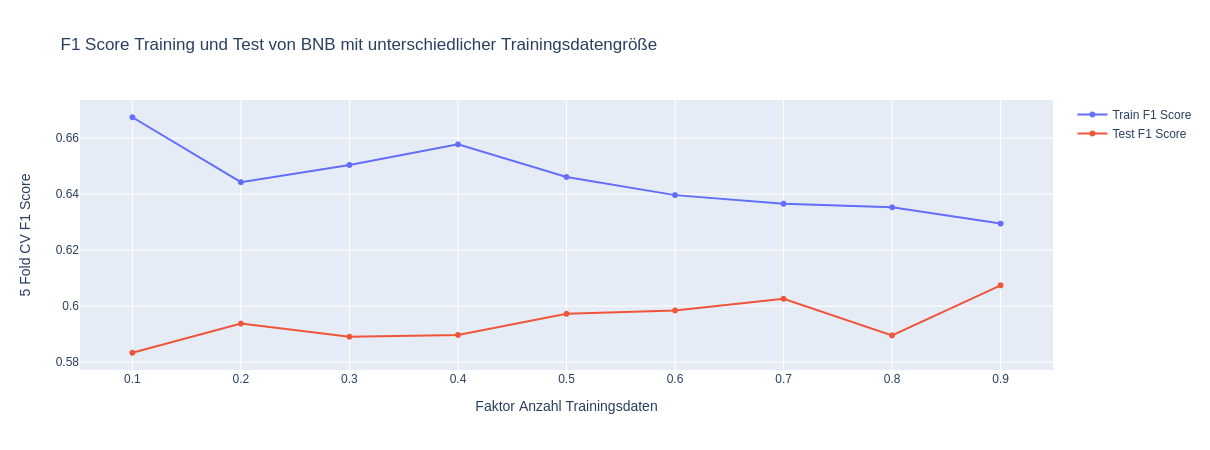

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import learning_curve, StratifiedKFold
import plotly.graph_objects as go

percentiles = [
    99.9,
    95,
    90,
    85,
    80,
    75,
    70,
    65,
    60,
    55,
    50,
    45,
    40,
    35,
    30,
    25,
    20,
    15,
    10,
    5,
    0.01
]

def custom_column_transformer(X):
    X_new = np.empty_like(X)
    for i in range(X.shape[1]):
        bins = [np.percentile(X[:,i], p) for p in percentiles]
        binned = np.digitize(X[:,i], bins, right=False)
        X_new[:,i] = binned

    return X_new


clf = BernoulliNB()

ct = ColumnTransformer(
        transformers=[
            ("binning", FunctionTransformer(func=custom_column_transformer), continous_features_idx),
        ],
        remainder="passthrough",
        n_jobs=os.cpu_count())

X_new = ct.fit_transform(X)
X_new = OneHotEncoder(sparse=False).fit_transform(X_new)
X_new = VarianceThreshold().fit_transform(X_new)

plot_diff_train_size_f1(clf, X_new, y, "BNB")

## Random Forest

best:
- adasyn
- F1 Score: 0.798
- ROC AUC: 0.989
- Bot AUC: 0.952
- Bot type AUC: 0.950

### Basic

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

clf = RandomForestClassifier(random_state=42, n_jobs=os.cpu_count())
pipeline = Pipeline([("clf", clf)])

param_grid = {
    "clf__max_depth": range(29, 33, 1),
    "clf__criterion": ["gini"],
    "clf__max_features": range(114, 118, 1)
}

gs = CustomGridSearchCV(pipeline, estimator_params=param_grid, n_fold=2)
scores = gs.fit(X, y, label_names)
best_params_idx = np.argmax(scores["f1_scores"])
pp.pprint(scores["f1_scores"][best_params_idx])
pp.pprint(scores["params"][best_params_idx])
# pp.pprint(scores["fold_scores"][best_params_idx])

Number of fits: 16
16/16 (avg 781.94s/job)0.7748580457082933
({'clf__criterion': 'gini', 'clf__max_depth': 31, 'clf__max_features': 116}, {})


- gini
- depth=31
- features=116

F1 Score (macro): 0.775
ROC AUC (macro): 0.980
Human Bot AUC: 0.990
Bot type AUC (macro): 0.992
content
	F1 Score (mean): 0.865
	ROC AUC (mean): 0.995
fake_follower
	F1 Score (mean): 0.603
	ROC AUC (mean): 0.973
feed
	F1 Score (mean): 0.848
	ROC AUC (mean): 0.992
game
	F1 Score (mean): 0.150
	ROC AUC (mean): 0.895
human
	F1 Score (mean): 0.952
	ROC AUC (mean): 0.990
political
	F1 Score (mean): 0.925
	ROC AUC (mean): 0.998
service
	F1 Score (mean): 0.554
	ROC AUC (mean): 0.972
social_spam
	F1 Score (mean): 0.988
	ROC AUC (mean): 0.998
stock
	F1 Score (mean): 0.982
	ROC AUC (mean): 0.998
traditional_spam
	F1 Score (mean): 0.881
	ROC AUC (mean): 0.986


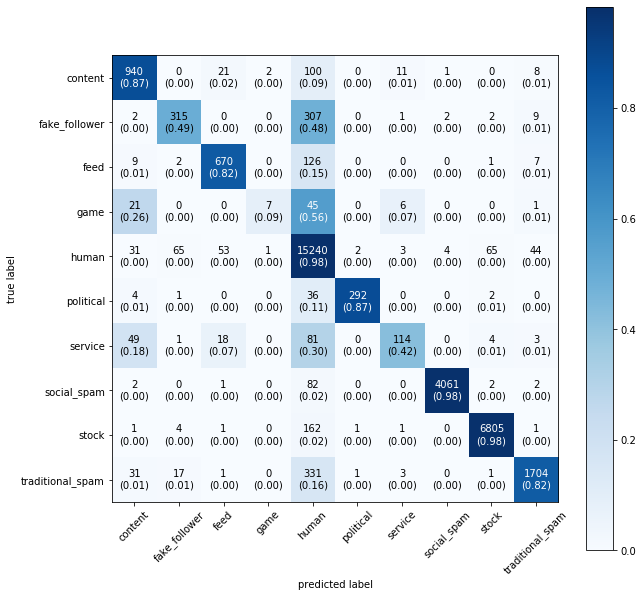

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

clf = RandomForestClassifier(max_depth=31, max_features=116, criterion="gini", random_state=42, n_jobs=os.cpu_count())
pipeline = Pipeline([("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

### oversampling game class

#### adasyn

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN

clf = RandomForestClassifier(random_state=42, n_jobs=os.cpu_count())

pipeline = Pipeline([
    ("adasyn", ADASYN(random_state=42, n_jobs=os.cpu_count())),
    ("clf", clf)])

params = {
    "clf__max_depth": range(35, 46, 1),
    "clf__criterion": ["gini"],
    "clf__max_features": range(75, 86, 1),
    "adasyn__n_neighbors": range(43,48,1),
    "adasyn__sampling_strategy": [{3:800}]
}

gs = CustomGridSearchCV(pipeline, params=params)
scores = gs.fit(X, y, label_names)
best_params_idx = np.argmax(scores["f1_scores"])
pp.pprint(scores["f1_scores"][best_params_idx])
pp.pprint(scores["params"][best_params_idx])
# pp.pprint(scores["fold_scores"][best_params_idx])

best:
- rf:
1. max depth: 40
2. criterion: gini
3. max features: 80
- adasyn:
1. k neigbors: 45
2. sampling strategy: 3:800

F1 Score (macro): 0.798
ROC AUC (macro): 0.989
Human Bot AUC: 0.991
Bot type AUC (macro): 0.993
content
	F1 Score (mean): 0.864
	ROC AUC (mean): 0.996
fake_follower
	F1 Score (mean): 0.598
	ROC AUC (mean): 0.975
feed
	F1 Score (mean): 0.849
	ROC AUC (mean): 0.993
game
	F1 Score (mean): 0.380
	ROC AUC (mean): 0.976
human
	F1 Score (mean): 0.953
	ROC AUC (mean): 0.991
political
	F1 Score (mean): 0.927
	ROC AUC (mean): 0.999
service
	F1 Score (mean): 0.559
	ROC AUC (mean): 0.981
social_spam
	F1 Score (mean): 0.988
	ROC AUC (mean): 0.998
stock
	F1 Score (mean): 0.982
	ROC AUC (mean): 0.998
traditional_spam
	F1 Score (mean): 0.879
	ROC AUC (mean): 0.988


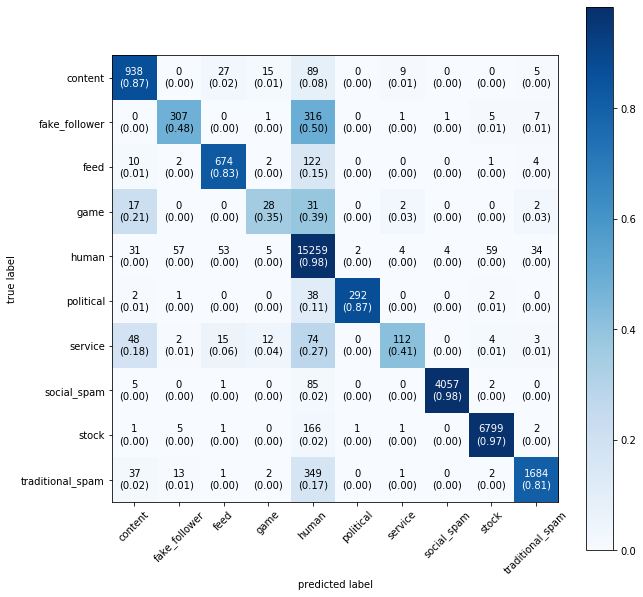

In [33]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN

clf = RandomForestClassifier(max_depth=40, max_features=80, criterion="gini", random_state=42, n_jobs=os.cpu_count())

pipeline = Pipeline([
    ("adasyn", ADASYN(sampling_strategy={3:800}, n_neighbors=45, random_state=42, n_jobs=os.cpu_count())),
    ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

#### smote

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

clf = RandomForestClassifier(random_state=42, n_jobs=os.cpu_count())

pipeline = Pipeline([
    ("smote", SMOTE(random_state=42, n_jobs=os.cpu_count())),
    ("clf", clf)])

params = {
    "clf__max_depth": range(1, 150, 30),
    "clf__criterion": ["entropy", "gini"],
    "clf__max_features": range(1, X.shape[1] + 1, 30),
    "smote__k_neighbors": range(1,51,1),
    "smote__sampling_strategy": [{3:500}, {3:800}]
}

gs = CustomGridSearchCV(pipeline, params=params)
scores = gs.fit(X, y, label_names)
best_params_idx = np.argmax(scores["f1_scores"])
pp.pprint(scores["f1_scores"][best_params_idx])
pp.pprint(scores["params"][best_params_idx])
# pp.pprint(scores["fold_scores"][best_params_idx])

best:
- rf:
1. max depth: 30
2. criterion: gini
3. max features: 79
- smote:
1. k neigbors: 7
2. sampling strategy: 3:800

F1 Score (macro): 0.795
ROC AUC (macro): 0.984
Human Bot AUC: 0.990
Bot type AUC (macro): 0.992
content
	F1 Score (mean): 0.872
	ROC AUC (mean): 0.996
fake_follower
	F1 Score (mean): 0.593
	ROC AUC (mean): 0.974
feed
	F1 Score (mean): 0.851
	ROC AUC (mean): 0.994
game
	F1 Score (mean): 0.343
	ROC AUC (mean): 0.939
human
	F1 Score (mean): 0.952
	ROC AUC (mean): 0.990
political
	F1 Score (mean): 0.927
	ROC AUC (mean): 0.998
service
	F1 Score (mean): 0.567
	ROC AUC (mean): 0.967
social_spam
	F1 Score (mean): 0.988
	ROC AUC (mean): 0.998
stock
	F1 Score (mean): 0.982
	ROC AUC (mean): 0.998
traditional_spam
	F1 Score (mean): 0.879
	ROC AUC (mean): 0.988


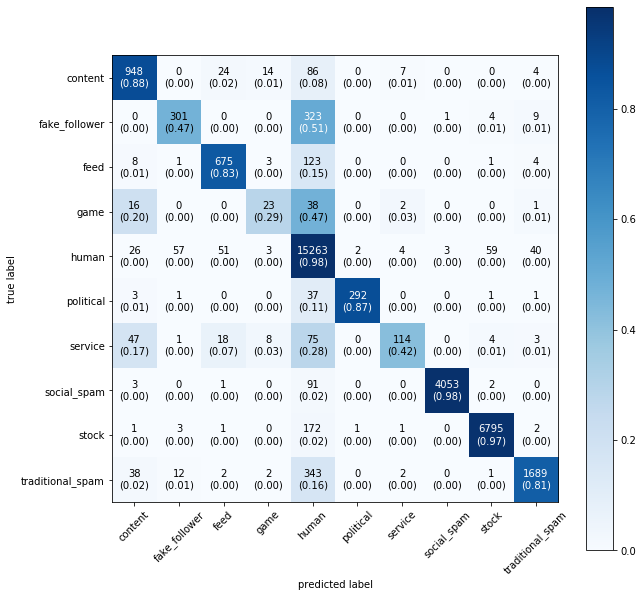

In [34]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

clf = RandomForestClassifier(max_depth=30, max_features=79, criterion="gini", random_state=42, n_jobs=os.cpu_count())

pipeline = Pipeline([
    ("smote", SMOTE(sampling_strategy={3:800}, k_neighbors=7, random_state=42, n_jobs=os.cpu_count())),
    ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

### Feature importance

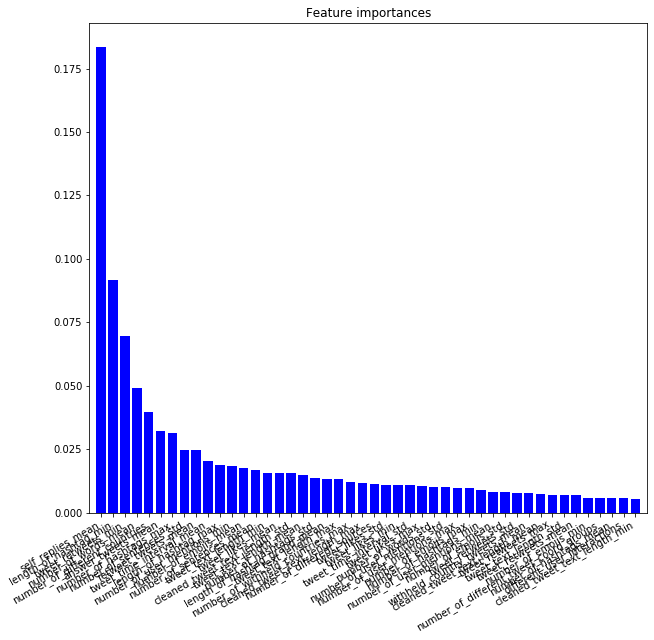

In [39]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN

clf = RandomForestClassifier(max_depth=40, max_features=80, criterion="gini", random_state=42, n_jobs=os.cpu_count())

pipeline = Pipeline([
    ("adasyn", ADASYN(sampling_strategy={3:800}, n_neighbors=45, random_state=42, n_jobs=os.cpu_count())),
    ("clf", clf)])

pipeline.fit(X, y)
importances = clf.feature_importances_
importances = importances[np.argwhere(importances > 0.005)].reshape(1,-1)[0]
indices = np.argsort(importances)[::-1]

f_names = np.asarray(user_features_index)

fig = plt.figure(figsize=(10,10))

plt.title("Feature importances")
plt.bar(f_names[indices], importances[indices],
       color="b", align="center")
plt.xlim([-1, importances.shape[0]])
fig.autofmt_xdate()
plt.show()

### different train sizes

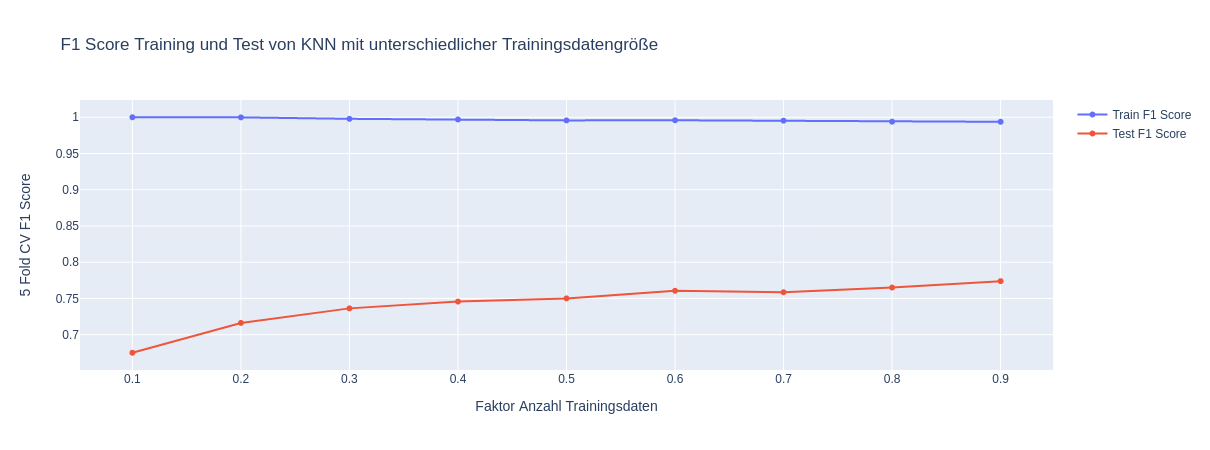

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

clf = RandomForestClassifier(max_depth=31, max_features=116, criterion="gini", random_state=42, n_jobs=os.cpu_count())
pipeline = Pipeline([("clf", clf)])

plot_diff_train_size_f1(pipeline, X, y, "KNN")

## Decision Tree:

Best model:
- basic
- F1 Score: 0.703
- ROC AUC: 0.851
- Bot AUC: 0.926
- Bot type AUC: 0.919

### Basic

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

clf = DecisionTreeClassifier()
pipeline = Pipeline([("clf", clf)])

estimator_params = {
    "clf__max_depth": range(12,16, 1),
    "clf__criterion": ["entropy"],
    "clf__max_features": range(150, 156, 1)
}

gs = CustomGridSearchCV(pipeline, estimator_params=estimator_params)
scores = gs.fit(X, y, label_names)
best_params_idx = np.argmax(scores["f1_scores"])
pp.pprint(scores["f1_scores"][best_params_idx])
pp.pprint(scores["params"][best_params_idx])
# pp.pprint(scores["fold_scores"][best_params_idx])

Number of fits: 24
24/24 (avg 28.14s/job)0.7112589064057845
(   {   'clf__criterion': 'entropy',
        'clf__max_depth': 15,
        'clf__max_features': 154},
    {})


- max_depth: 15
- max_features: 154
- entropy

F1 Score (macro): 0.693
ROC AUC (macro): 0.850
Human Bot AUC: 0.925
Bot type AUC (macro): 0.922
content
	F1 Score (mean): 0.767
	ROC AUC (mean): 0.889
fake_follower
	F1 Score (mean): 0.429
	ROC AUC (mean): 0.706
feed
	F1 Score (mean): 0.717
	ROC AUC (mean): 0.867
game
	F1 Score (mean): 0.118
	ROC AUC (mean): 0.587
human
	F1 Score (mean): 0.925
	ROC AUC (mean): 0.925
political
	F1 Score (mean): 0.844
	ROC AUC (mean): 0.933
service
	F1 Score (mean): 0.389
	ROC AUC (mean): 0.730
social_spam
	F1 Score (mean): 0.972
	ROC AUC (mean): 0.984
stock
	F1 Score (mean): 0.971
	ROC AUC (mean): 0.980
traditional_spam
	F1 Score (mean): 0.800
	ROC AUC (mean): 0.904


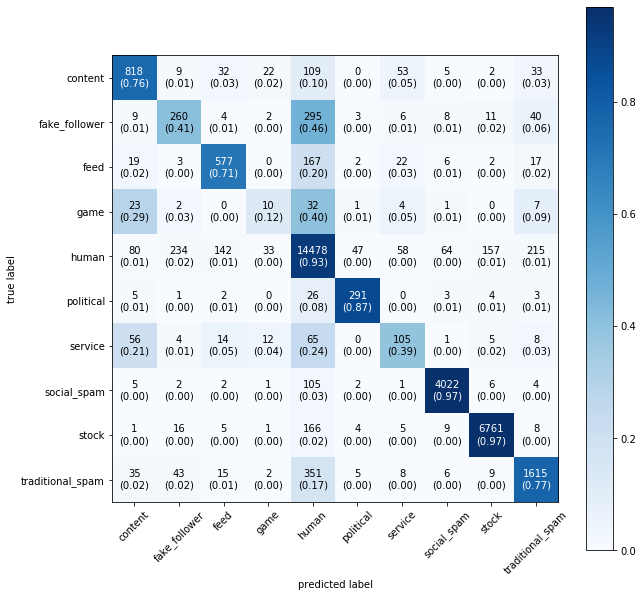

In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

clf = DecisionTreeClassifier(max_depth=15, criterion="entropy", max_features=154)
pipeline = Pipeline([("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

### oversampling game class

#### adasyn

In [ ]:
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import ADASYN

clf = DecisionTreeClassifier()

pipeline = Pipeline([
    ("adasyn", ADASYN(random_state=42, n_jobs=os.cpu_count())),
    ("clf", clf)])

params = {
    "clf__max_depth": range(1, 150, 30),
    "clf__criterion": ["entropy", "gini"],
    "clf__max_features": range(1, X.shape[1] + 1, 30),
    "adasyn__n_neighbors": range(1,61,20),
    "adasyn__sampling_strategy": [{3:250}, {3:500}, {3:800}]
}

gs = CustomGridSearchCV(pipeline, params=params)
scores = gs.fit(X, y, label_names)
best_params_idx = np.argmax(scores["f1_scores"])
pp.pprint(scores["f1_scores"][best_params_idx])
pp.pprint(scores["params"][best_params_idx])
# pp.pprint(scores["fold_scores"][best_params_idx])

F1 Score (macro): 0.692
ROC AUC (macro): 0.840
Human Bot AUC: 0.921
Bot type AUC (macro): 0.915
content
	F1 Score (mean): 0.759
	ROC AUC (mean): 0.871
fake_follower
	F1 Score (mean): 0.459
	ROC AUC (mean): 0.723
feed
	F1 Score (mean): 0.737
	ROC AUC (mean): 0.859
game
	F1 Score (mean): 0.101
	ROC AUC (mean): 0.579
human
	F1 Score (mean): 0.919
	ROC AUC (mean): 0.921
political
	F1 Score (mean): 0.870
	ROC AUC (mean): 0.932
service
	F1 Score (mean): 0.359
	ROC AUC (mean): 0.673
social_spam
	F1 Score (mean): 0.963
	ROC AUC (mean): 0.980
stock
	F1 Score (mean): 0.969
	ROC AUC (mean): 0.980
traditional_spam
	F1 Score (mean): 0.782
	ROC AUC (mean): 0.882


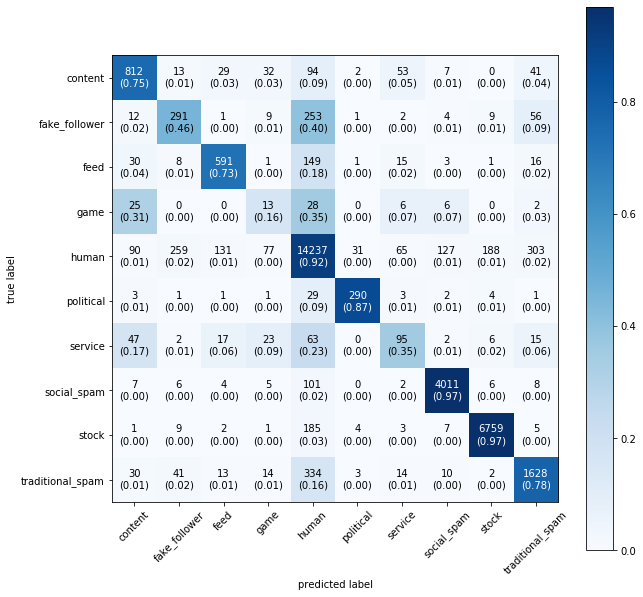

In [36]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN

clf = DecisionTreeClassifier(max_depth=100, criterion="entropy", max_features=164)

pipeline = Pipeline([
    ("adasyn", ADASYN(sampling_strategy={3:800}, n_neighbors=20, random_state=42, n_jobs=os.cpu_count())),
    ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

#### smote

In [ ]:
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

clf = DecisionTreeClassifier()

pipeline = Pipeline([
    ("smote", SMOTE(random_state=42, n_jobs=os.cpu_count())),
    ("clf", clf)])

params = {
    "clf__max_depth": range(1, 150, 30),
    "clf__criterion": ["entropy", "gini"],
    "clf__max_features": range(1, X.shape[1] + 1, 30),
    "smote__k_neighbors": range(1,61,20),
    "smote__sampling_strategy": [{3:250}, {3:500}, {3:800}]
}

gs = CustomGridSearchCV(pipeline, params=params)
scores = gs.fit(X, y, label_names)
best_params_idx = np.argmax(scores["f1_scores"])
pp.pprint(scores["f1_scores"][best_params_idx])
pp.pprint(scores["params"][best_params_idx])
# pp.pprint(scores["fold_scores"][best_params_idx])

F1 Score (macro): 0.698
ROC AUC (macro): 0.836
Human Bot AUC: 0.921
Bot type AUC (macro): 0.914
content
	F1 Score (mean): 0.762
	ROC AUC (mean): 0.845
fake_follower
	F1 Score (mean): 0.465
	ROC AUC (mean): 0.702
feed
	F1 Score (mean): 0.707
	ROC AUC (mean): 0.834
game
	F1 Score (mean): 0.164
	ROC AUC (mean): 0.617
human
	F1 Score (mean): 0.927
	ROC AUC (mean): 0.921
political
	F1 Score (mean): 0.823
	ROC AUC (mean): 0.905
service
	F1 Score (mean): 0.381
	ROC AUC (mean): 0.679
social_spam
	F1 Score (mean): 0.967
	ROC AUC (mean): 0.979
stock
	F1 Score (mean): 0.971
	ROC AUC (mean): 0.977
traditional_spam
	F1 Score (mean): 0.812
	ROC AUC (mean): 0.901


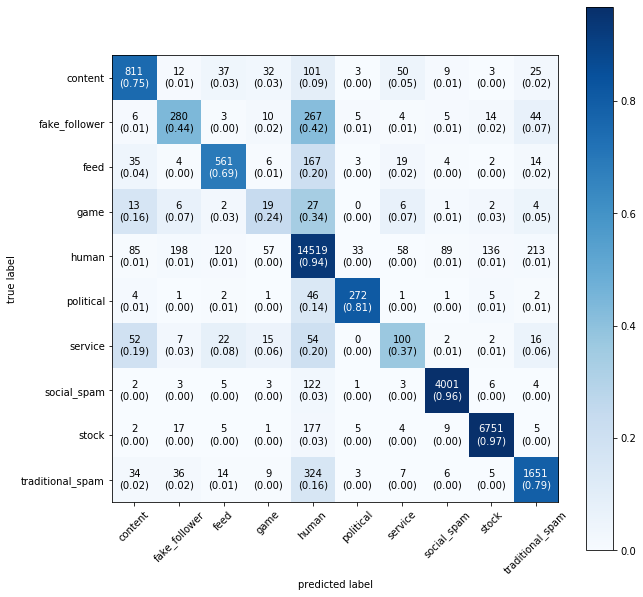

In [37]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

clf = DecisionTreeClassifier(max_depth=20, criterion="gini", max_features=159)

pipeline = Pipeline([
    ("smote", SMOTE(sampling_strategy={3:800}, k_neighbors=13, random_state=42, n_jobs=os.cpu_count())),
    ("clf", clf)])

eval_scores = evaluate_model(pipeline, X, y, label_names)
print_eval(eval_scores, label_names, console_confm_print=False)

### Feature importance

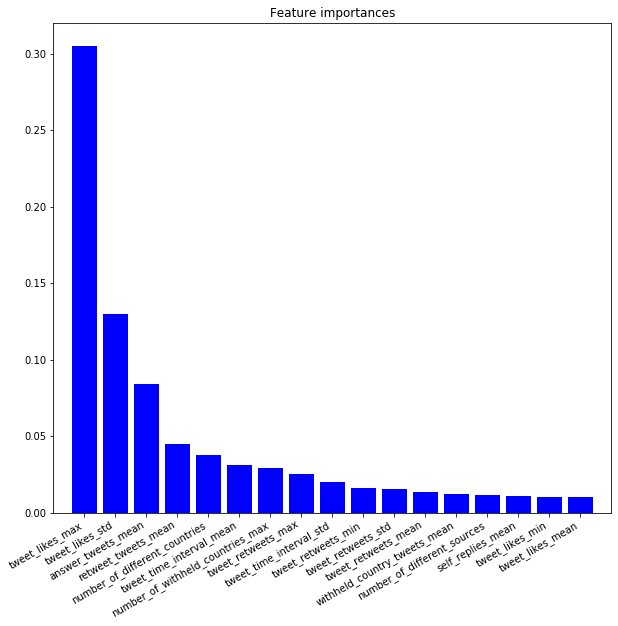

In [20]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

clf = DecisionTreeClassifier(max_depth=15, criterion="entropy", max_features=154)

clf.fit(X, y)
importances = clf.feature_importances_
importances = importances[np.argwhere(importances > 0.01)].reshape(1,-1)[0]
indices = np.argsort(importances)[::-1]

f_names = np.asarray(user_features_index)

fig = plt.figure(figsize=(10,10))

plt.title("Feature importances")
plt.bar(f_names[indices], importances[indices],
       color="b", align="center")
plt.xlim([-1, importances.shape[0]])
fig.autofmt_xdate()
plt.show()

### different train sizes

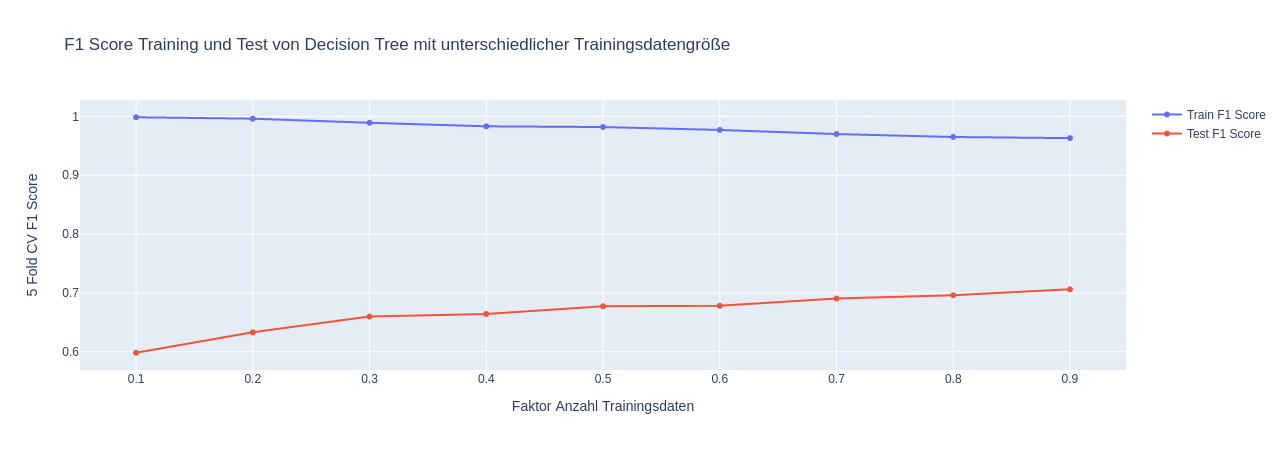

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

clf = DecisionTreeClassifier(max_depth=15, criterion="entropy", max_features=154)
pipeline = Pipeline([("clf", clf)])

plot_diff_train_size_f1(pipeline, X, y, "Decision Tree")

## Deep Neuronal Network

Best model:
- ADASYN
- F1 Score: 0.792
- ROC AUC: 0.983
- Bot AUC: 0.949
- Bot type AUC: 0.945
- LOG LOSS: 0.319

### Basic

scale values between 0 and 1

Restoring model weights from the end of the best epoch.
Epoch 00354: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00297: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00243: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00298: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00243: early stopping
F1 Score (macro): 0.795
ROC AUC (macro): 0.980
Human Bot AUC: 0.985
Bot type AUC (macro): 0.988
LOG LOSS (mean): 0.350
content
	F1 Score (mean): 0.852
	ROC AUC (mean): 0.993
fake_follower
	F1 Score (mean): 0.593
	ROC AUC (mean): 0.954
feed
	F1 Score (mean): 0.824
	ROC AUC (mean): 0.991
game
	F1 Score (mean): 0.357
	ROC AUC (mean): 0.942
human
	F1 Score (mean): 0.950
	ROC AUC (mean): 0.985
political
	F1 Score (mean): 0.958
	ROC AUC (mean): 0.996
service
	F1 Score (mean): 0.575
	ROC AUC (mean): 0.965
social_spam
	F1 Score (mean): 0.985
	ROC AUC (mean): 0.997
stock
	F1 Score (

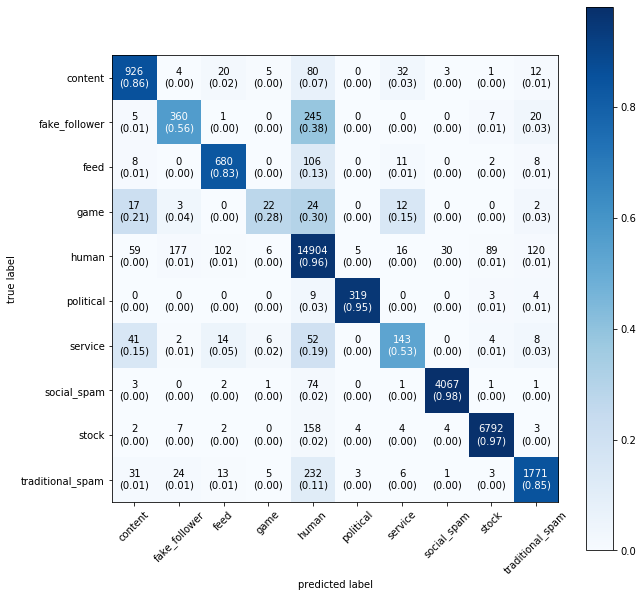

In [50]:
import tensorflow as tf
from sklearn.metrics import f1_score, roc_curve, accuracy_score, confusion_matrix, log_loss, auc, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

X_min_max = MinMaxScaler().fit_transform(X)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(X.shape[1], activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(150, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(80, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

es = tf.keras.callbacks.EarlyStopping(monitor="sparse_categorical_accuracy", mode="max", patience=15, restore_best_weights=True, verbose=1)

scores = {"f1_scores": [], "roc_auc_macro": [], "confusion_matrices": [], "bot_aucs": [], "bot_type_aucs": [],
              "class_scores": {}, "fpr_macro": [], "tpr_macro": [], "log_loss": []}

for l in label_names:
    scores["class_scores"][l] = {
        "f1_scores": [],
        "roc_aucs": [],
        "fpr": [],
        "tpr": []
    }


for train_index, test_index in StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(X_min_max, y):
    f1_scores = []

    X_train, X_test = X_min_max[train_index], X_min_max[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = tf.keras.models.clone_model(model)
    
    model.compile(
      optimizer=tf.keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999),
      loss="sparse_categorical_crossentropy",
      metrics=["sparse_categorical_accuracy"]
    )

    model.fit(X_train,
      y_train,
      epochs=800,
      batch_size=64,
      callbacks=[es],
      verbose=0)
    
    y_pred_prob = model.predict_proba(X_test)

    y_true = OneHotEncoder().fit_transform(y_test.reshape(-1, 1)).toarray()

    fpr = dict()
    tpr = dict()
    roc_aucs = dict()
    for i, l in enumerate(label_names):
        fpr[l], tpr[l], _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
        roc_aucs[l] = auc(fpr[l], tpr[l])

    all_fpr = np.unique(np.concatenate([fpr[l] for l in label_names]))

    mean_tpr = np.zeros_like(all_fpr)
    for l in label_names:
        mean_tpr += np.interp(all_fpr, fpr[l], tpr[l])

    mean_tpr /= len(label_names)
        
    scores["fpr_macro"] = all_fpr
    scores["tpr_macro"] = mean_tpr

    y_pred = np.argmax(y_pred_prob, axis=1)

    f1_scores = f1_score(y_test, y_pred, average=None)
        
    mean_fpr = np.linspace(0, 1, 10)

    for i, l in enumerate(label_names):
        scores["class_scores"][l]["f1_scores"].append(f1_scores[i])
        scores["class_scores"][l]["roc_aucs"].append(roc_aucs[l])
            
        scores["class_scores"][l]["fpr"].append(fpr[l])
        scores["class_scores"][l]["tpr"].append(tpr[l])            

    scores["f1_scores"].append(np.mean(f1_scores))
    scores["roc_auc_macro"].append(auc(all_fpr, mean_tpr))
    scores["confusion_matrices"].append(confusion_matrix(y_test, y_pred))

    scores["log_loss"].append(log_loss(y_test, y_pred_prob, eps=1e-15))

    y_test_2 = np.copy(y_test)
    y_test_2[y_test_2 != label_names.index("human")] = -1
        
    # column 0: bot
    # column 1: human
    y_test_2_oh = OneHotEncoder().fit_transform(y_test_2.reshape(-1,1)).toarray()
        
    y_pred_prob_2 = np.zeros((y_pred_prob.shape[0], 2))
        
    y_pred_prob_2[:,1] = y_pred_prob[:,label_names.index("human")]
        
    y_pred_prob_2[:,0] = y_pred_prob[:, [i for i, n in enumerate(label_names) if n != "human"]].sum(axis=1)
        
    scores["bot_aucs"].append(roc_auc_score(y_test_2_oh, y_pred_prob_2))

    y_test_2 = np.copy(y_test)
    # good bots
    y_test_2[y_test_2 == label_names.index("content")] = -2
    y_test_2[y_test_2 == label_names.index("feed")] = -2
    y_test_2[y_test_2 == label_names.index("game")] = -2
    y_test_2[y_test_2 == label_names.index("service")] = -2
    # bad bots
    y_test_2[y_test_2 == label_names.index("fake_follower")] = -1
    y_test_2[y_test_2 == label_names.index("political")] = -1
    y_test_2[y_test_2 == label_names.index("social_spam")] = -1
    y_test_2[y_test_2 == label_names.index("stock")] = -1
    y_test_2[y_test_2 == label_names.index("traditional_spam")] = -1
        
    # column 0: good bot
    # column 1: bad bot
    # column 2: human
    y_test_2_oh = OneHotEncoder().fit_transform(y_test_2.reshape(-1,1)).toarray()

    y_pred_prob_2 = np.zeros((y_pred_prob.shape[0], 3))
    # good bots
    y_pred_prob_2[:,0] = y_pred_prob[:, [i for i, n in enumerate(label_names) if n in ["content", "feed", "game", "service"]]].sum(axis=1)
    # bad bots
    y_pred_prob_2[:,1] = y_pred_prob[:, [i for i, n in enumerate(label_names) if n in ["fake_follower", "political", "social_spam", "stock", "traditional_spam"]]].sum(axis=1)
        
    y_pred_prob_2[:,2] = y_pred_prob[:,label_names.index("human")]
                                                         
    scores["bot_type_aucs"].append(roc_auc_score(y_test_2_oh, y_pred_prob_2, average="macro", multi_class="ovr"))

print_eval(scores, label_names, console_confm_print=False)

### Oversampling game class

#### adasyn

In [ ]:
import tensorflow as tf
from sklearn.metrics import f1_score, roc_curve, accuracy_score, confusion_matrix, log_loss, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

X_min_max = MinMaxScaler().fit_transform(X)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(X.shape[1], activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(150, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(80, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

es = tf.keras.callbacks.EarlyStopping(monitor="sparse_categorical_accuracy", mode="max", patience=15, restore_best_weights=True, verbose=1)

res = []

for i in range(1,17,2):

    for train_index, test_index in StratifiedKFold(n_splits=3, shuffle=True, random_state=42).split(X_min_max, y):
        f1_scores = []

        X_train, X_test = X_min_max[train_index], X_min_max[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train, y_train = oversampling_adasyn(X_train, y_train, {"n_neighbors" : i, "sampling_strategy": {3:800}})

        model = tf.keras.models.clone_model(model)

        model.compile(
            optimizer=tf.keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999),
            loss="sparse_categorical_crossentropy",
            metrics=["sparse_categorical_accuracy"]
        )

        model.fit(
            X_train,
            y_train,
            epochs=800,
            batch_size=64,
            callbacks=[es],
            verbose=0
        )

        y_pred_prob = model.predict_proba(X_test)
        
        y_pred = np.argmax(y_pred_prob, axis=1)

        f1_scores = f1_score(y_test, y_pred, average=None)

        res.append((i, f1_scores))

r = {}
for i in res:
    if i[0] in r:
        r[i[0]].append(np.mean(i[1]))
    else:
        r[i[0]] = [np.mean(i[1])]
    
for i, f in r.items():
    print(i, np.mean(f))

best:
 - k_neighbors: 1
 - sampling_strategy: 800

Restoring model weights from the end of the best epoch.
Epoch 00215: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00314: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00241: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00227: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00250: early stopping
F1 Score (macro): 0.791
ROC AUC (macro): 0.981
Human Bot AUC: 0.986
Bot type AUC (macro): 0.988
LOG LOSS (mean): 0.340
content
	F1 Score (mean): 0.841
	ROC AUC (mean): 0.992
fake_follower
	F1 Score (mean): 0.578
	ROC AUC (mean): 0.952
feed
	F1 Score (mean): 0.811
	ROC AUC (mean): 0.993
game
	F1 Score (mean): 0.350
	ROC AUC (mean): 0.938
human
	F1 Score (mean): 0.948
	ROC AUC (mean): 0.986
political
	F1 Score (mean): 0.952
	ROC AUC (mean): 0.999
service
	F1 Score (mean): 0.590
	ROC AUC (mean): 0.971
social_spam
	F1 Score (mean): 0.985
	ROC AUC (mean): 0.997
stock
	F1 Score (

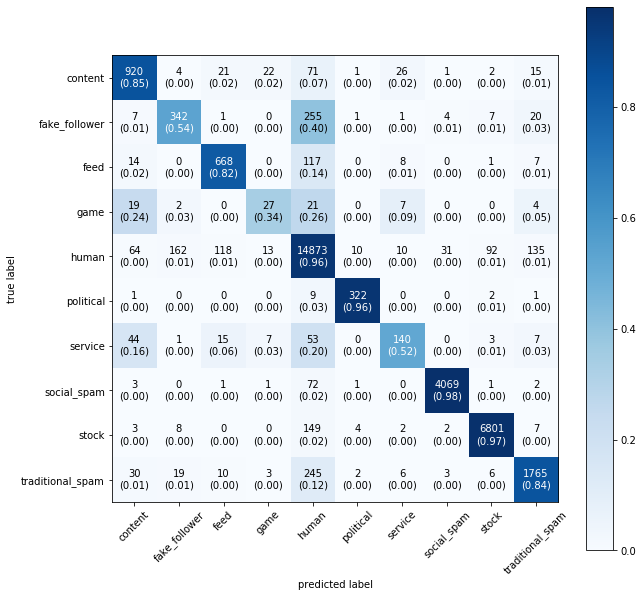

In [51]:
import tensorflow as tf
from sklearn.metrics import f1_score, roc_curve, accuracy_score, confusion_matrix, log_loss, auc, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

X_min_max = MinMaxScaler().fit_transform(X)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(X.shape[1], activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(150, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(80, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

es = tf.keras.callbacks.EarlyStopping(monitor="sparse_categorical_accuracy", mode="max", patience=15, restore_best_weights=True, verbose=1)

scores = {"f1_scores": [], "roc_auc_macro": [], "confusion_matrices": [], "bot_aucs": [], "bot_type_aucs": [],
              "class_scores": {}, "fpr_macro": [], "tpr_macro": [], "log_loss": []}

for l in label_names:
    scores["class_scores"][l] = {
        "f1_scores": [],
        "roc_aucs": [],
        "fpr": [],
        "tpr": []
    }


for train_index, test_index in StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(X_min_max, y):
    f1_scores = []

    X_train, X_test = X_min_max[train_index], X_min_max[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train, y_train = oversampling_adasyn(X_train, y_train, {"n_neighbors": 1, "sampling_strategy": {3:800}})
    
    model = tf.keras.models.clone_model(model)
    
    model.compile(
      optimizer=tf.keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999),
      loss="sparse_categorical_crossentropy",
      metrics=["sparse_categorical_accuracy"]
    )

    model.fit(X_train,
      y_train,
      epochs=800,
      batch_size=64,
      callbacks=[es],
      verbose=0)
    
    y_pred_prob = model.predict_proba(X_test)

    y_true = OneHotEncoder().fit_transform(y_test.reshape(-1, 1)).toarray()

    fpr = dict()
    tpr = dict()
    roc_aucs = dict()
    for i, l in enumerate(label_names):
        fpr[l], tpr[l], _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
        roc_aucs[l] = auc(fpr[l], tpr[l])

    all_fpr = np.unique(np.concatenate([fpr[l] for l in label_names]))

    mean_tpr = np.zeros_like(all_fpr)
    for l in label_names:
        mean_tpr += np.interp(all_fpr, fpr[l], tpr[l])

    mean_tpr /= len(label_names)
        
    scores["fpr_macro"] = all_fpr
    scores["tpr_macro"] = mean_tpr

    y_pred = np.argmax(y_pred_prob, axis=1)

    f1_scores = f1_score(y_test, y_pred, average=None)
        
    mean_fpr = np.linspace(0, 1, 10)

    for i, l in enumerate(label_names):
        scores["class_scores"][l]["f1_scores"].append(f1_scores[i])
        scores["class_scores"][l]["roc_aucs"].append(roc_aucs[l])
            
        scores["class_scores"][l]["fpr"].append(fpr[l])
        scores["class_scores"][l]["tpr"].append(tpr[l])            

    scores["f1_scores"].append(np.mean(f1_scores))
    scores["roc_auc_macro"].append(auc(all_fpr, mean_tpr))
    scores["confusion_matrices"].append(confusion_matrix(y_test, y_pred))

    scores["log_loss"].append(log_loss(y_test, y_pred_prob, eps=1e-15))

    y_test_2 = np.copy(y_test)
    y_test_2[y_test_2 != label_names.index("human")] = -1
        
    # column 0: bot
    # column 1: human
    y_test_2_oh = OneHotEncoder().fit_transform(y_test_2.reshape(-1,1)).toarray()
        
    y_pred_prob_2 = np.zeros((y_pred_prob.shape[0], 2))
        
    y_pred_prob_2[:,1] = y_pred_prob[:,label_names.index("human")]
        
    y_pred_prob_2[:,0] = y_pred_prob[:, [i for i, n in enumerate(label_names) if n != "human"]].sum(axis=1)
        
    scores["bot_aucs"].append(roc_auc_score(y_test_2_oh, y_pred_prob_2))

    y_test_2 = np.copy(y_test)
    # good bots
    y_test_2[y_test_2 == label_names.index("content")] = -2
    y_test_2[y_test_2 == label_names.index("feed")] = -2
    y_test_2[y_test_2 == label_names.index("game")] = -2
    y_test_2[y_test_2 == label_names.index("service")] = -2
    # bad bots
    y_test_2[y_test_2 == label_names.index("fake_follower")] = -1
    y_test_2[y_test_2 == label_names.index("political")] = -1
    y_test_2[y_test_2 == label_names.index("social_spam")] = -1
    y_test_2[y_test_2 == label_names.index("stock")] = -1
    y_test_2[y_test_2 == label_names.index("traditional_spam")] = -1
        
    # column 0: good bot
    # column 1: bad bot
    # column 2: human
    y_test_2_oh = OneHotEncoder().fit_transform(y_test_2.reshape(-1,1)).toarray()

    y_pred_prob_2 = np.zeros((y_pred_prob.shape[0], 3))
    # good bots
    y_pred_prob_2[:,0] = y_pred_prob[:, [i for i, n in enumerate(label_names) if n in ["content", "feed", "game", "service"]]].sum(axis=1)
    # bad bots
    y_pred_prob_2[:,1] = y_pred_prob[:, [i for i, n in enumerate(label_names) if n in ["fake_follower", "political", "social_spam", "stock", "traditional_spam"]]].sum(axis=1)
        
    y_pred_prob_2[:,2] = y_pred_prob[:,label_names.index("human")]
                                                         
    scores["bot_type_aucs"].append(roc_auc_score(y_test_2_oh, y_pred_prob_2, average="macro", multi_class="ovr"))

print_eval(scores, label_names, console_confm_print=False)

#### smote

In [ ]:
import tensorflow as tf
from sklearn.metrics import f1_score, roc_curve, accuracy_score, confusion_matrix, log_loss, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sampling.sampling import oversampling_smote

X_min_max = MinMaxScaler().fit_transform(X)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(X.shape[1], activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(150, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(80, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

es = tf.keras.callbacks.EarlyStopping(monitor="sparse_categorical_accuracy", mode="max", patience=15, restore_best_weights=True, verbose=1)

res = []

for i in range(1,17,2):

    for train_index, test_index in StratifiedKFold(n_splits=3, shuffle=True, random_state=42).split(X_min_max, y):
        f1_scores = []

        X_train, X_test = X_min_max[train_index], X_min_max[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train, y_train = oversampling_smote(X_train, y_train, {"k_neighbors" : i, "sampling_strategy": {3:800}})

        model = tf.keras.models.clone_model(model)

        model.compile(
            optimizer=tf.keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999),
            loss="sparse_categorical_crossentropy",
            metrics=["sparse_categorical_accuracy"]
        )

        model.fit(
            X_train,
            y_train,
            epochs=800,
            batch_size=64,
            callbacks=[es],
            verbose=0
        )

        y_pred_prob = model.predict_proba(X_test)
        
        y_pred = np.argmax(y_pred_prob, axis=1)

        f1_scores = f1_score(y_test, y_pred, average=None)

        res.append((i, f1_scores))

r = {}
for i in res:
    if i[0] in r:
        r[i[0]].append(np.mean(i[1]))
    else:
        r[i[0]] = [np.mean(i[1])]
    
for i, f in r.items():
    print(i, np.mean(f))

best:
 - k_neighbors: 7
 - sampling_strategy: 800

Restoring model weights from the end of the best epoch.
Epoch 00326: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00205: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00264: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00299: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00390: early stopping
F1 Score (macro): 0.787
ROC AUC (macro): 0.979
Human Bot AUC: 0.985
Bot type AUC (macro): 0.988
LOG LOSS (mean): 0.361
content
	F1 Score (mean): 0.835
	ROC AUC (mean): 0.992
fake_follower
	F1 Score (mean): 0.572
	ROC AUC (mean): 0.952
feed
	F1 Score (mean): 0.827
	ROC AUC (mean): 0.990
game
	F1 Score (mean): 0.344
	ROC AUC (mean): 0.927
human
	F1 Score (mean): 0.946
	ROC AUC (mean): 0.985
political
	F1 Score (mean): 0.956
	ROC AUC (mean): 1.000
service
	F1 Score (mean): 0.561
	ROC AUC (mean): 0.963
social_spam
	F1 Score (mean): 0.983
	ROC AUC (mean): 0.997
stock
	F1 Score (

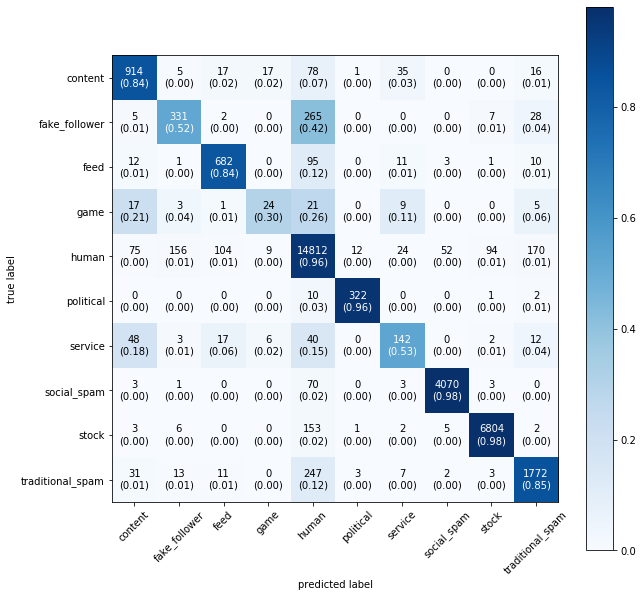

In [52]:
import tensorflow as tf
from sklearn.metrics import f1_score, roc_curve, accuracy_score, confusion_matrix, log_loss, auc, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

X_min_max = MinMaxScaler().fit_transform(X)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(X.shape[1], activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(150, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(80, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

es = tf.keras.callbacks.EarlyStopping(monitor="sparse_categorical_accuracy", mode="max", patience=15, restore_best_weights=True, verbose=1)

scores = {"f1_scores": [], "roc_auc_macro": [], "confusion_matrices": [], "bot_aucs": [], "bot_type_aucs": [],
              "class_scores": {}, "fpr_macro": [], "tpr_macro": [], "log_loss": []}

for l in label_names:
    scores["class_scores"][l] = {
        "f1_scores": [],
        "roc_aucs": [],
        "fpr": [],
        "tpr": []
    }


for train_index, test_index in StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(X_min_max, y):
    f1_scores = []

    X_train, X_test = X_min_max[train_index], X_min_max[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train, y_train = oversampling_smote(X_train, y_train, {"k_neighbors" : 7, "sampling_strategy": {3:800}})
    
    model = tf.keras.models.clone_model(model)
    
    model.compile(
      optimizer=tf.keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999),
      loss="sparse_categorical_crossentropy",
      metrics=["sparse_categorical_accuracy"]
    )

    model.fit(X_train,
      y_train,
      epochs=800,
      batch_size=64,
      callbacks=[es],
      verbose=0)
    
    y_pred_prob = model.predict_proba(X_test)

    y_true = OneHotEncoder().fit_transform(y_test.reshape(-1, 1)).toarray()

    fpr = dict()
    tpr = dict()
    roc_aucs = dict()
    for i, l in enumerate(label_names):
        fpr[l], tpr[l], _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
        roc_aucs[l] = auc(fpr[l], tpr[l])

    all_fpr = np.unique(np.concatenate([fpr[l] for l in label_names]))

    mean_tpr = np.zeros_like(all_fpr)
    for l in label_names:
        mean_tpr += np.interp(all_fpr, fpr[l], tpr[l])

    mean_tpr /= len(label_names)
        
    scores["fpr_macro"] = all_fpr
    scores["tpr_macro"] = mean_tpr

    y_pred = np.argmax(y_pred_prob, axis=1)

    f1_scores = f1_score(y_test, y_pred, average=None)
        
    mean_fpr = np.linspace(0, 1, 10)

    for i, l in enumerate(label_names):
        scores["class_scores"][l]["f1_scores"].append(f1_scores[i])
        scores["class_scores"][l]["roc_aucs"].append(roc_aucs[l])
            
        scores["class_scores"][l]["fpr"].append(fpr[l])
        scores["class_scores"][l]["tpr"].append(tpr[l])            

    scores["f1_scores"].append(np.mean(f1_scores))
    scores["roc_auc_macro"].append(auc(all_fpr, mean_tpr))
    scores["confusion_matrices"].append(confusion_matrix(y_test, y_pred))

    scores["log_loss"].append(log_loss(y_test, y_pred_prob, eps=1e-15))

    y_test_2 = np.copy(y_test)
    y_test_2[y_test_2 != label_names.index("human")] = -1
        
    # column 0: bot
    # column 1: human
    y_test_2_oh = OneHotEncoder().fit_transform(y_test_2.reshape(-1,1)).toarray()
        
    y_pred_prob_2 = np.zeros((y_pred_prob.shape[0], 2))
        
    y_pred_prob_2[:,1] = y_pred_prob[:,label_names.index("human")]
        
    y_pred_prob_2[:,0] = y_pred_prob[:, [i for i, n in enumerate(label_names) if n != "human"]].sum(axis=1)
        
    scores["bot_aucs"].append(roc_auc_score(y_test_2_oh, y_pred_prob_2))

    y_test_2 = np.copy(y_test)
    # good bots
    y_test_2[y_test_2 == label_names.index("content")] = -2
    y_test_2[y_test_2 == label_names.index("feed")] = -2
    y_test_2[y_test_2 == label_names.index("game")] = -2
    y_test_2[y_test_2 == label_names.index("service")] = -2
    # bad bots
    y_test_2[y_test_2 == label_names.index("fake_follower")] = -1
    y_test_2[y_test_2 == label_names.index("political")] = -1
    y_test_2[y_test_2 == label_names.index("social_spam")] = -1
    y_test_2[y_test_2 == label_names.index("stock")] = -1
    y_test_2[y_test_2 == label_names.index("traditional_spam")] = -1
        
    # column 0: good bot
    # column 1: bad bot
    # column 2: human
    y_test_2_oh = OneHotEncoder().fit_transform(y_test_2.reshape(-1,1)).toarray()

    y_pred_prob_2 = np.zeros((y_pred_prob.shape[0], 3))
    # good bots
    y_pred_prob_2[:,0] = y_pred_prob[:, [i for i, n in enumerate(label_names) if n in ["content", "feed", "game", "service"]]].sum(axis=1)
    # bad bots
    y_pred_prob_2[:,1] = y_pred_prob[:, [i for i, n in enumerate(label_names) if n in ["fake_follower", "political", "social_spam", "stock", "traditional_spam"]]].sum(axis=1)
        
    y_pred_prob_2[:,2] = y_pred_prob[:,label_names.index("human")]
                                                         
    scores["bot_type_aucs"].append(roc_auc_score(y_test_2_oh, y_pred_prob_2, average="macro", multi_class="ovr"))

print_eval(scores, label_names, console_confm_print=False)

### different train sizes

Restoring model weights from the end of the best epoch.
Epoch 00205: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00099: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00134: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00124: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00217: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00242: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00125: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00193: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00216: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00204: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00165: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00164: early s

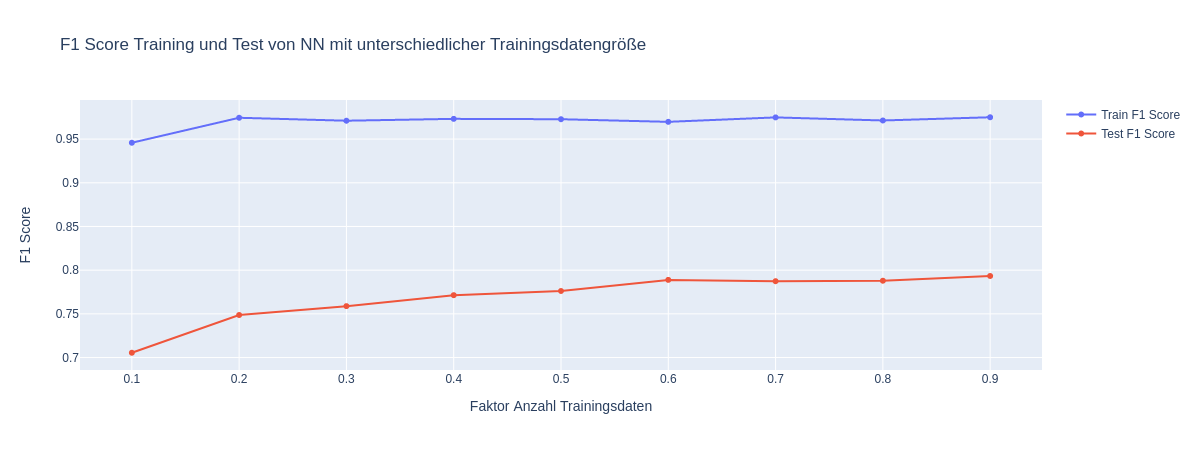

In [19]:
import tensorflow as tf
from sklearn.metrics import f1_score, log_loss
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

X_min_max = MinMaxScaler().fit_transform(X)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(X.shape[1], activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(150, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(80, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

es = tf.keras.callbacks.EarlyStopping(monitor="sparse_categorical_accuracy", mode="max", patience=15, restore_best_weights=True, verbose=1)

train_sizes = []
train_scores_mean = []
test_scores_mean = []

train_size_factors = np.linspace(0.1, 0.9, 9)

for size in train_size_factors:
    
    train_sizes.append(int(X.shape[0] * size))
    
    test_scores_fold = []
    train_scores_fold = []

    for train_index, test_index in StratifiedShuffleSplit(n_splits=5, train_size=size, random_state=42).split(X_min_max, y):
        f1_scores = []

        X_train, X_test = X_min_max[train_index], X_min_max[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = tf.keras.models.clone_model(model)

        model.compile(
          optimizer=tf.keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999),
          loss="sparse_categorical_crossentropy",
          metrics=["sparse_categorical_accuracy"]
        )

        model.fit(X_train,
          y_train,
          epochs=800,
          batch_size=64,
          callbacks=[es],
          verbose=0)

        y_pred_prob = model.predict_proba(X_test)
        y_pred = np.argmax(y_pred_prob, axis=1)
        test_scores_fold.append(np.mean(f1_score(y_test, y_pred, average=None)))
        
        y_pred_prob = model.predict_proba(X_train)
        y_pred = np.argmax(y_pred_prob, axis=1)
        train_scores_fold.append(np.mean(f1_score(y_train, y_pred, average=None)))

    test_scores_mean.append(np.mean(test_scores_fold))
    train_scores_mean.append(np.mean(train_scores_fold))
    
fig = go.Figure(data=[
    go.Scatter(x=train_size_factors, y=train_scores_mean, name="Train F1 Score"),
    go.Scatter(x=train_size_factors, y=test_scores_mean, name="Test F1 Score"),
])
fig.update_layout(title="F1 Score Training und Test von NN mit unterschiedlicher Trainingsdatengröße",
                   xaxis_title="Faktor Anzahl Trainingsdaten",
                   yaxis_title="F1 Score")
fig.show()